# Libraries

In [3]:
import os
import sys

current_dir = os.getcwd()
resources_folder = os.path.join(current_dir, '..', 'resources')
sys.path.append(resources_folder)

os.listdir()

['1_validate_initial_files.ipynb', '2_retrain_otr_adjudication.ipynb']

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from typing import List, Dict, Optional, Tuple
from statsmodels.discrete.discrete_model import Logit, BinaryResultsWrapper
from sklearn.metrics import roc_auc_score, average_precision_score


import snowflake_connector as sc
import model_training as mt


# Data reading and processing

## Data reading

In [5]:
sf_conn = sc.snowflake_conn(user = "W515059")

c:\Users\W515059\AppData\Local\Programs\Python\Python38\lib\site-packages\snowflake\connector\config_manager.py:344: UserWarning: Bad owner or permissions on C:\Users\W515059\.snowflake\connections.toml
  warn(f"Bad owner or permissions on {str(filep)}{chmod_message}")


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://myapps.wexinc.com/app/snowflake/exkaea789nRrm6HV7357/sso/saml?SAMLRequest=pZPNctowFEZfxaOubcmOU0CDydBQBlJIKT9ph52wL0TFlhxdGcPbV5jQSRfJpjtZPlc6up%2FUvTsWuXcAg1KrhIQBIx6oVGdS7RKyWg79NvHQCpWJXCtIyAmQ3PW6KIq85P3KPqs5vFSA1nMLKeTNj4RURnEtUCJXogDkNuWL%2FnTCo4Dx0mirU52TNyUfVwhEMNYZXksylE7v2dqSU1rXdVDfBNrsaMQYo6xDHXVGPl35ozvTO3xIWXzmHeHw2avbF6kuLfhIa3OBkI%2BWy5k%2F%2B75YEq9%2FVb3XCqsCzALMQaawmk8uAugMNi%2BCtdoxCyr0a9c7PwpKIw%2FCQi7VPkCl620u9pDqoqys2yJwI7qFjOZ6J10XxoOElHuZjaaqtfn1e1p31uphtpY%2FWsOH1cvo56HzVRSriYVa7GNm5ORbPyXe0zXm6BzzGLGCsTqHa90Ui2I%2FjPyQLcOIRxGP4%2BC2Ha6JN3CCUgnbVF5PUJxEWWJQw1GqtLFz3%2FSvOIXjXoBotTtqborPo6fWzW2LImp6Dptc7g9vDEzvv7rSpW%2BXer2Xjy6q8WCmc5mevKE2hbDvJxkGYTMjM3%2FboBwKIfN%2BlhlAdInmua7vDTiPhFhTAaG9y67%2FPoDeHw%3D%3D&

In [6]:
query = ''' 
        SELECT *
        FROM "SRC_RISK_FRAUD_SUB"."RISK_FRAUD"."OTR_ADJ_RISK_PREPROCESSED_SAMPLE_MODEL_MONITORING";
    '''

cur = sf_conn.cursor()
cur.execute(query)
df = pd.DataFrame.from_records(iter(cur), columns=[x[0] for x in cur.description])

df.head()

,application_number,ar_id,booked,decision_date,number_of_trucks_c,program_group,product_type_c,fraud_flag_c,existing_exposure_check_c,credit_line_requested_c,...,lexis_nexis_reason_code_4_c,adverse_action_code_c,offer_c,detailed_funding_type_2024,pg_required_c,b2bcnt2y_ln,sbfecardcount_ln,sbfeaccountcount_ln,sbfehitindex_ln,years_in_business_num_c
0,528133,-1,False,2022-08-14,4.0,RTS Fleet One,OTR,False,Passed,15200.0,...,None,A2,a3L700000004RGEEA2,UNKNOWN,True,1.0,-99.0,-99.0,1.0,3.0
1,302755,-1,False,2019-10-02,2.0,XPO Logistics,OTR - LLC,False,Failed,5000.0,...,None,None,a3L0g000000HLfBEAW,UNKNOWN,False,NaN,NaN,NaN,NaN,7.0
2,441624,-1,False,2021-11-18,3.0,XPO Logistics,OTR,False,Passed,10800.0,...,None,F5,a3L0g000000HLfBEAW,UNKNOWN,False,0.0,-99.0,-99.0,1.0,8.0
3,714153,-1,False,2024-06-04,3.0,other,OTR,False,Failed,0.0,...,None,B7,a3L4u000001O351EAC,child_funded,False,1.0,1.0,2.0,3.0,18.0
4,617592,-1,False,2023-06-07,7.0,other,OTR,False,Passed,0.0,...,None,F7,a3L0g000000HPMwEAO,UNKNOWN,False,NaN,NaN,NaN,NaN,3.0


## Data processing

In [7]:
# Select data for model development and for testing purposes
data_dev, filters_applied_dev = mt.build_model_development_sample(data=df)
data_test, filters_applied_test = mt.build_model_application_sample(data=df)
data_scoring, filters_applied_scoring = mt.build_model_scoring_sample(data=df)

Original data shape: (324327, 67)
Filters applied for model development sample: {'original_rows': 53416, 'unique_apps': 53416, 'remove_existing_exposure': 43136, 'remove_prepaid_deposit': 38754, 'remove_credit_line_approved_lt_1': 35424, 'remove_security_deposit': 35240, 'remove_credit_line_gt_150k': 35116, 'remove_fraud_flag': 34975, 'remove_first_payment_default': 34872, 'remove_non_child_funded': 34872}
Filters applied for model application sample: {'original_rows': 19494, 'unique_apps': 19494, 'remove_existing_exposure': 14215, 'remove_prepaid_deposit': 12736, 'remove_credit_line_approved_lt_1': 11533, 'remove_security_deposit': 11492, 'remove_credit_line_gt_150k': 11458, 'remove_fraud_flag': 11400, 'remove_first_payment_default': 11256, 'remove_non_child_funded': 11256}
Filters applied for model scoring sample: {'original_rows': 36111, 'unique_apps': 35859, 'remove_existing_exposure': 27952, 'remove_prepaid_deposit': 16915, 'remove_credit_line_approved_lt_1': 16760, 'remove_securi

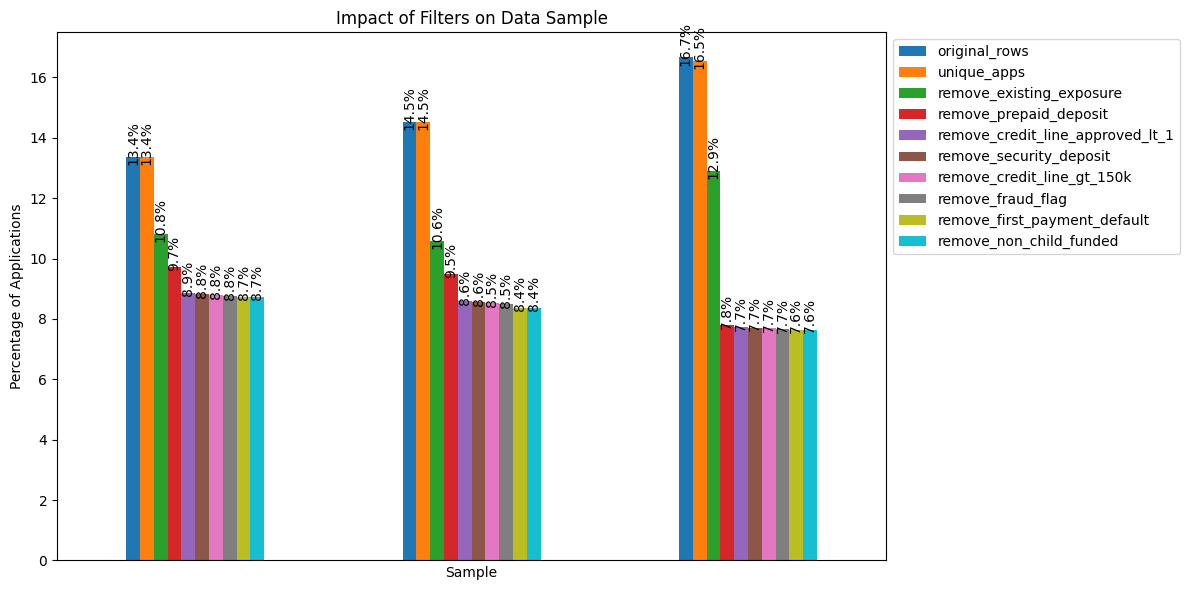

In [8]:
print(f"Original data shape: {df.shape}")
print(f"Filters applied for model development sample: {filters_applied_dev}")
print(f"Filters applied for model application sample: {filters_applied_test}")
print(f"Filters applied for model scoring sample: {filters_applied_scoring}")

mt.filters_applied_chart(filters_applied_dev, filters_applied_test, filters_applied_scoring)

Model development Through the door number of transactions: 34872


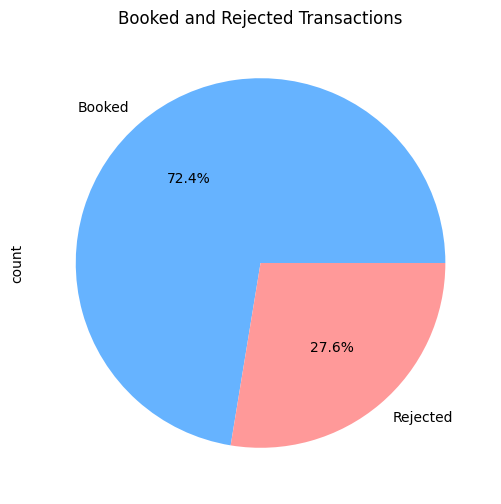

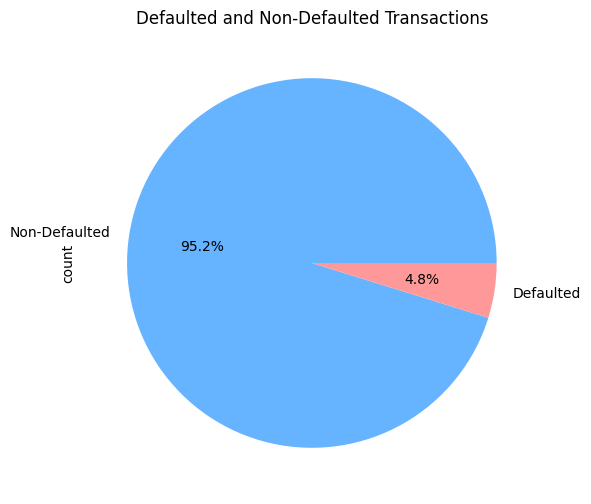

In [9]:
print(f"Model development Through the door number of transactions: {data_dev.shape[0]}")
mt.booked_rejected_pie_chart(data_dev)
mt.default_pie_chart(data_dev)

Model application  Through the door number of transactions: 11256


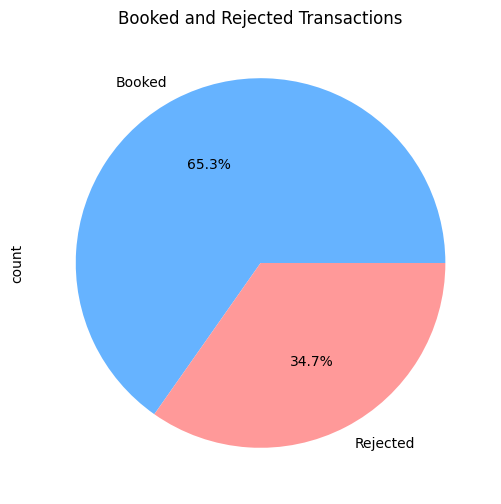

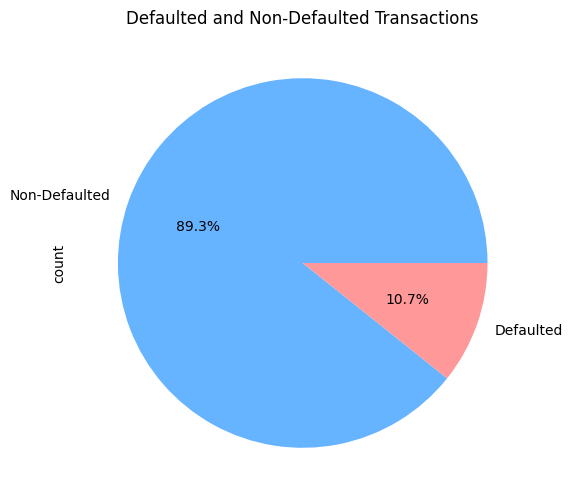

In [10]:
print(f"Model application  Through the door number of transactions: {data_test.shape[0]}")
mt.booked_rejected_pie_chart(data_test)
mt.default_pie_chart(data_test)

Model scoring Through the door number of transactions: 16576


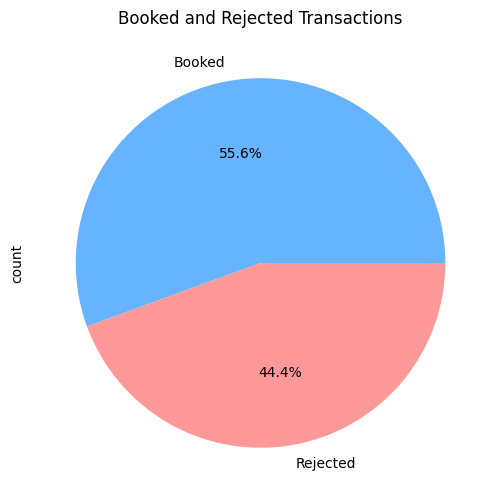

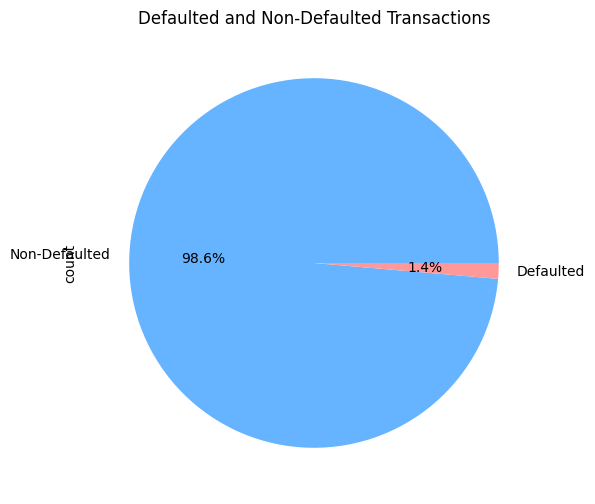

In [11]:
print(f"Model scoring Through the door number of transactions: {data_scoring.shape[0]}")
mt.booked_rejected_pie_chart(data_scoring)
mt.default_pie_chart(data_scoring)

# Current Model

In [12]:
# Define the conditions and choices once ----- current model

conditions = [
    (lambda df: (df['sbfecardcount_ln'] >= 0)),
    (lambda df: (df['sbfecardcount_ln'] < 0) & (df['b2bcnt2y_ln'] >= 0)),
    (lambda df: (df['sbfecardcount_ln'] < 0) & (df['b2bcnt2y_ln'] < 0)),
    (lambda df: (df['sbfecardcount_ln'].isnull()) & (df['b2bcnt2y_ln'].isnull()))
]

choices = [
    'sbfe',
    'sba',
    'double_no_hit',
    'UNKNOWN'
]

# Apply the function to both dataframes
data_dev = mt.apply_risk_grade_path(data_dev, conditions, choices)
data_test = mt.apply_risk_grade_path(data_test, conditions, choices)
data_scoring = mt.apply_risk_grade_path(data_scoring, conditions, choices)


# Segments for risk calibration
CONDITION_SBFE = {
    "column": "ln_segment",
    "allowed_values": ["sbfe"],
}
CONDITION_SBA = {
    "column": "ln_segment",
    "allowed_values": ["sba"],
}
CONDITION_LN_NOHIT = {
    "column": "ln_segment",
    "allowed_values": ["double_no_hit", "UNKNOWN"],
}


RISK_GRADE_SEGMENTS = {
    "sbfe_ln_and_fico": {
        "condition": CONDITION_SBFE,
        "model_cols": ["intercept", "ln_score", "fico_score_filled", "no_fico"],
        "train_filter": "booked",
        "core_model_vars": ["fico_score", "ln_score"],
    },  # LN SBFE hit, use blended score of LN and FICO
    "sba_ln_and_fico": {
        "condition": CONDITION_SBA,
        "model_cols": ["intercept", "ln_score", "fico_score_filled", "no_fico"],
        "train_filter": "booked",
        "core_model_vars": ["fico_score", "ln_score"],
    },  # LN SBFE hit, use blended score of LN and FICO
    "no_hit": {
        "condition": CONDITION_LN_NOHIT,
        "model_cols": ["intercept", "fico_score"],
        "train_filter": "booked & has_fico",
        "core_model_vars": ["fico_score"],
    },  # LN no-hit, use only FICO score
}


NORMALIZE_SCORES = False

In [13]:
data_dev_filtered = mt.risk_grade_estimate_preprocessing(data_dev)

models_dict, normalization_dict = mt.fit_models_for_segments(data_dev_filtered, RISK_GRADE_SEGMENTS, NORMALIZE_SCORES)

print(mt.generate_model_parameters_df(models_dict=models_dict))

data_test_filtered = mt.risk_grade_estimate_preprocessing(data_test)

data_scoring_filtered = mt.risk_grade_estimate_preprocessing(data_scoring)

data_dev_scored = mt.apply_fitted_models_to_data(
    data=data_dev_filtered,
    models_dict=models_dict,
    normalization_dict=normalization_dict,
    RISK_GRADE_SEGMENTS=RISK_GRADE_SEGMENTS,
)

data_test_scored = mt.apply_fitted_models_to_data(
    data=data_test_filtered,
    models_dict=models_dict,
    normalization_dict=normalization_dict,
    RISK_GRADE_SEGMENTS=RISK_GRADE_SEGMENTS,
)

data_scoring_scored = mt.apply_fitted_models_to_data(
    data=data_scoring_filtered,
    models_dict=models_dict,
    normalization_dict=normalization_dict,
    RISK_GRADE_SEGMENTS=RISK_GRADE_SEGMENTS,
)

print(len(data_test_scored))
print(len(data_scoring_scored))


# Define the risk grade thresholds
new_pd_risk_grade_thresholds = {
    "1a": (0.00, 0.0009),
    "1b": (0.0009, 0.0022),
    "1c": (0.0022, 0.0066),
    "2a": (0.0066, 0.0110),
    "2b": (0.0110, 0.0165),
    "2c": (0.0165, 0.0248),
    "3a": (0.0248, 0.0371),
    "3b": (0.0371, 0.0464),
    "3c": (0.0464, 0.0557),
    "4a": (0.0557, 0.0835),
    "4b": (0.0835, 0.1040),
    "4c": (0.1040, 0.1280),
    "5a": (0.1280, 0.1570),
    "5b": (0.1570, 0.1930),
    "5c": (0.1930, 0.2370),
    "6a": (0.2370, 0.2910),
    "6b": (0.2910, 0.3570),
    "6c": (0.3570, 0.5000),
    "7a": (0.5000, 0.8140),
    "7b": (0.8140, 1.0000),
}

# Define the approval/decline thresholds based on risk grade
approval_thresholds = {
    "1a": True,
    "1b": True,
    "1c": True,
    "2a": True,
    "2b": True,
    "2c": True,
    "3a": True,
    "3b": True,
    "3c": True,
    "4a": False,  # Decline starts here
    "4b": False,
    "4c": False,
    "5a": False,
    "5b": False,
    "5c": False,
    "6a": False,
    "6b": False,
    "6c": False,
    "7a": False,
    "7b": False,
}



# Calculate segment statistics with approval/decline thresholds
segment_stats_df = mt.calculate_segment_statistics_with_approval(
    data=data_test_scored,
    RISK_GRADE_SEGMENTS=RISK_GRADE_SEGMENTS,
    risk_grade_thresholds=new_pd_risk_grade_thresholds,
    approval_thresholds=approval_thresholds,
)

# Display the results
print(segment_stats_df)

segment_stats_df = mt.calculate_segment_statistics_with_approval(
    data=data_scoring_scored,
    RISK_GRADE_SEGMENTS=RISK_GRADE_SEGMENTS,
    risk_grade_thresholds=new_pd_risk_grade_thresholds,
    approval_thresholds=approval_thresholds,
)

# Display the results
print(segment_stats_df)

c:\Users\W515059\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\W515059\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\discrete\discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
c:\Users\W515059\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\W515059\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\discrete\discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
c:\Users\W515059\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c

Optimization terminated successfully.
         Current function value: 0.109834
         Iterations: 38
         Function evaluations: 78
         Gradient evaluations: 73
Optimization terminated successfully.
         Current function value: 0.211978
         Iterations: 48
         Function evaluations: 71
         Gradient evaluations: 66


c:\Users\W515059\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\W515059\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\discrete\discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
c:\Users\W515059\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\W515059\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\discrete\discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully.
         Current function value: 0.101422
         Iterations: 21
         Function evaluations: 38
         Gradient evaluations: 34
            segment  intercept  ln_score  fico_score_filled    no_fico  \
0  sbfe_ln_and_fico  17.793105 -0.015805          -0.015814 -10.661057   
1   sba_ln_and_fico  14.917906 -0.011583          -0.014747  -9.490581   
2            no_hit   9.624301       NaN                NaN        NaN   

   fico_score  
0         NaN  
1         NaN  
2   -0.019338  
11256
16121
       segment_name  total_rows  num_booked  num_non_booked  booked_is_bad  \
0  sbfe_ln_and_fico        3828        2864             964            235   
1   sba_ln_and_fico        5994        3695            2299            490   
2            no_hit        1434         786             648             63   

   predicted_booked  predicted_booked_is_bad  predicted_declined  \
0              3074                      160                 754   
1     

In [14]:
normalization_dict

{'sbfe_ln_and_fico': None, 'sba_ln_and_fico': None, 'no_hit': None}

### AUC - PR AUC

In [15]:

df_performance = data_dev_scored.copy()
df_performance['segment'] = df_performance['risk_grade_path'].replace({'double_no_hit': 'no_hit_unknown', 'UNKNOWN': 'no_hit_unknown'})

# Calculate segment counts
segment_counts = df_performance['segment'].value_counts()

# Initialize dictionaries to store AUC and PR-AUC results
auc_results = {}
prauc_results = {}


for segment in df_performance['segment'].unique():
    segment_data = df_performance[df_performance['segment'] == segment]

    if segment == 'sbfe':
        y_true = (segment_data['is_bad']).astype(int)  # Convert boolean to integer
        y_score = segment_data['pd_sbfe_ln_and_fico']
        
    elif segment == 'sba':
        y_true = (segment_data['is_bad']).astype(int)
        y_score = segment_data['pd_sba_ln_and_fico']

    elif segment == 'no_hit_unknown':
        segment_data = segment_data.dropna(subset=['pd_no_hit'])
        y_true = (segment_data['is_bad']).astype(int)
        y_score = segment_data['pd_no_hit']
    else:
        continue  # Skip if any unexpected segment

    auc = roc_auc_score(y_true, y_score)
    auc_results[segment] = auc

    prauc = average_precision_score(y_true, y_score)
    prauc_results[segment] = prauc


# Print the results
print("Segment Counts:\n", segment_counts)
print("\nAUC Results:\n", auc_results)
print("\nPR-AUC Results:\n", prauc_results)


Segment Counts:
 segment
sba               21443
sbfe               8053
no_hit_unknown     5376
Name: count, dtype: int64

AUC Results:
 {'sbfe': 0.7719029171429781, 'sba': 0.6230950182930206, 'no_hit_unknown': 0.57157120036513}

PR-AUC Results:
 {'sbfe': 0.05549841998551982, 'sba': 0.056291554490246684, 'no_hit_unknown': 0.0161149877717435}


In [16]:

df_performance = data_test_scored.copy()
df_performance['segment'] = df_performance['risk_grade_path'].replace({'double_no_hit': 'no_hit_unknown', 'UNKNOWN': 'no_hit_unknown'})

# Calculate segment counts
segment_counts = df_performance['segment'].value_counts()

# Initialize dictionaries to store AUC and PR-AUC results
auc_results = {}
prauc_results = {}


for segment in df_performance['segment'].unique():
    segment_data = df_performance[df_performance['segment'] == segment]

    if segment == 'sbfe':
        y_true = (segment_data['is_bad']).astype(int)  # Convert boolean to integer
        y_score = segment_data['pd_sbfe_ln_and_fico']
        
    elif segment == 'sba':
        y_true = (segment_data['is_bad']).astype(int)
        y_score = segment_data['pd_sba_ln_and_fico']

    elif segment == 'no_hit_unknown':
        segment_data = segment_data.dropna(subset=['pd_no_hit'])
        y_true = (segment_data['is_bad']).astype(int)
        y_score = segment_data['pd_no_hit']
    else:
        continue  # Skip if any unexpected segment

    auc = roc_auc_score(y_true, y_score)
    auc_results[segment] = auc

    prauc = average_precision_score(y_true, y_score)
    prauc_results[segment] = prauc


# Print the results
print("Segment Counts:\n", segment_counts)
print("\nAUC Results:\n", auc_results)
print("\nPR-AUC Results:\n", prauc_results)


Segment Counts:
 segment
sba               5994
sbfe              3828
no_hit_unknown    1434
Name: count, dtype: int64

AUC Results:
 {'sbfe': 0.6494608310485518, 'sba': 0.5374008142501187, 'no_hit_unknown': 0.5387593527057596}

PR-AUC Results:
 {'sbfe': 0.0870877945957193, 'sba': 0.08198257832908971, 'no_hit_unknown': 0.034543222877666424}


### Lift Charts

#### SBFE

  risk_grade_path  booked  is_bad  count
0   double_no_hit   False   False    648
1   double_no_hit    True   False    723
2   double_no_hit    True    True     63
3             sba   False   False   2299
4             sba    True   False   3205
5             sba    True    True    490
6            sbfe   False   False    964
7            sbfe    True   False   2629
8            sbfe    True    True    235
11256


g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


11256


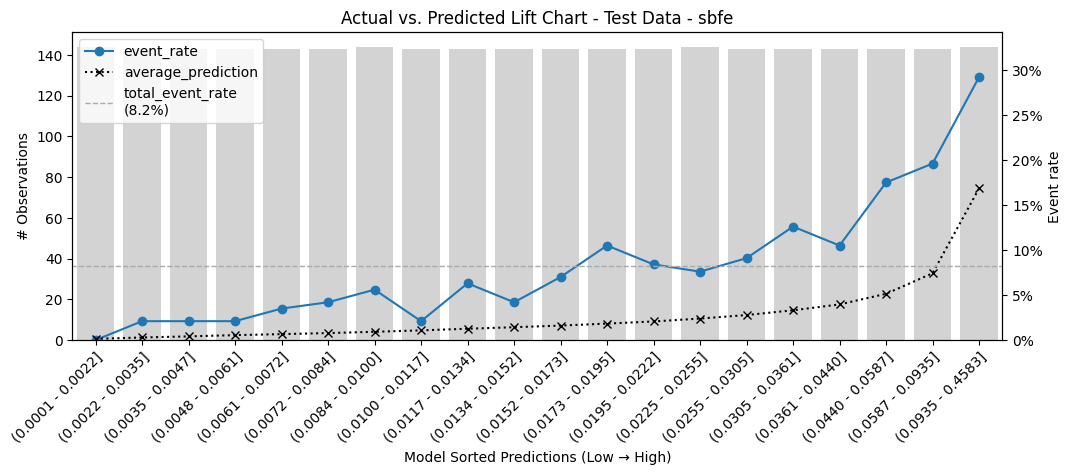

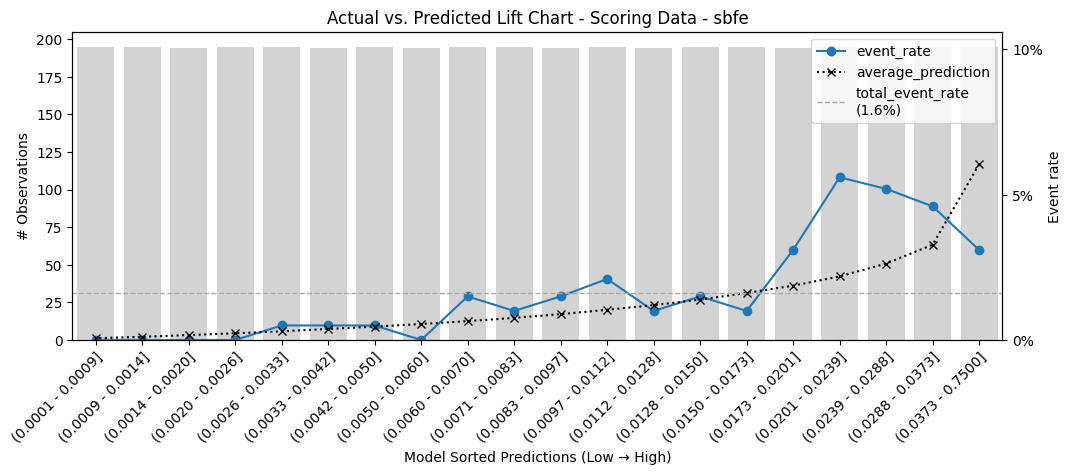

In [17]:
grouped_data = data_test_scored.groupby(["risk_grade_path", "booked", "is_bad"]).size().reset_index(name="count")

print(grouped_data)
print(sum(grouped_data["count"]))

mt.lift_chart_plot('Test Data - sbfe', mt.compute_decile_table(
        data_test_scored[data_test_scored['booked'] == True],
        'pd_sbfe_ln_and_fico',
        'is_bad',
        20,
        'sbfe'
), 'PROB_RANGE')


mt.lift_chart_plot('Scoring Data - sbfe', mt.compute_decile_table(
        data_scoring_scored[data_scoring_scored['booked'] == True],
        'pd_sbfe_ln_and_fico',
        'is_bad',
        20,
        'sbfe'
), 'PROB_RANGE')
print(len(data_test_scored))

#### SBA

g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


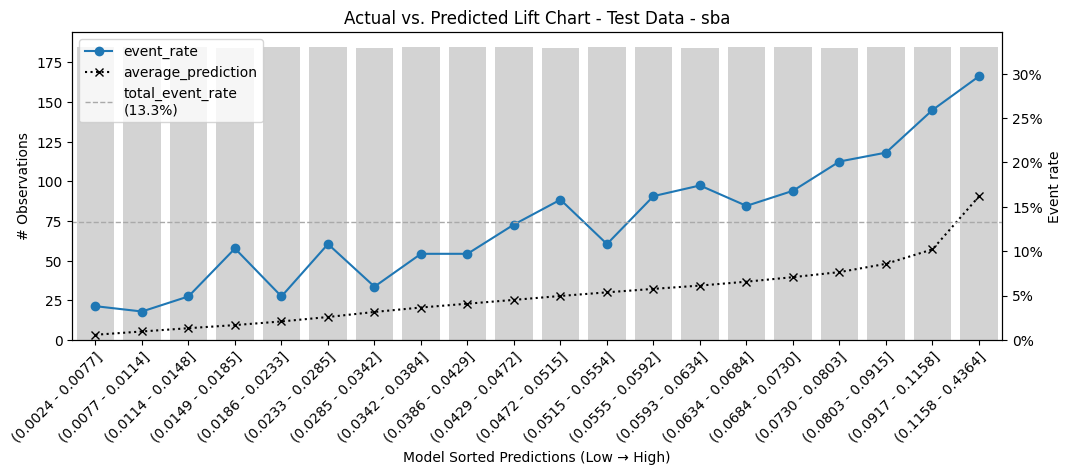

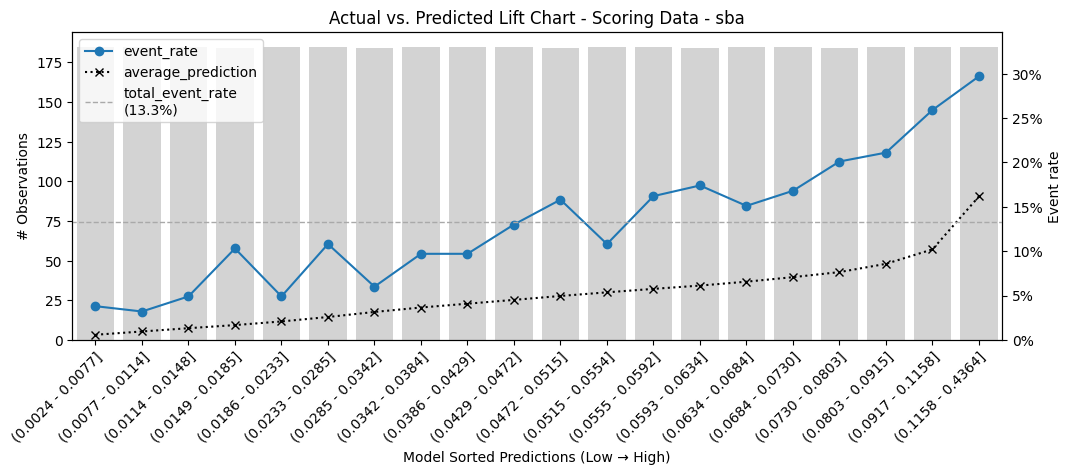

In [18]:

mt.lift_chart_plot('Test Data - sba', mt.compute_decile_table(
        data_test_scored[data_test_scored['booked']],
        'pd_sba_ln_and_fico',
        'is_bad',
        20,
        'sba'
), 'PROB_RANGE')


mt.lift_chart_plot('Scoring Data - sba', mt.compute_decile_table(
        data_test_scored[data_test_scored['booked']],
        'pd_sba_ln_and_fico',
        'is_bad',
        20,
        'sba'
), 'PROB_RANGE')

#### No - Hit

g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


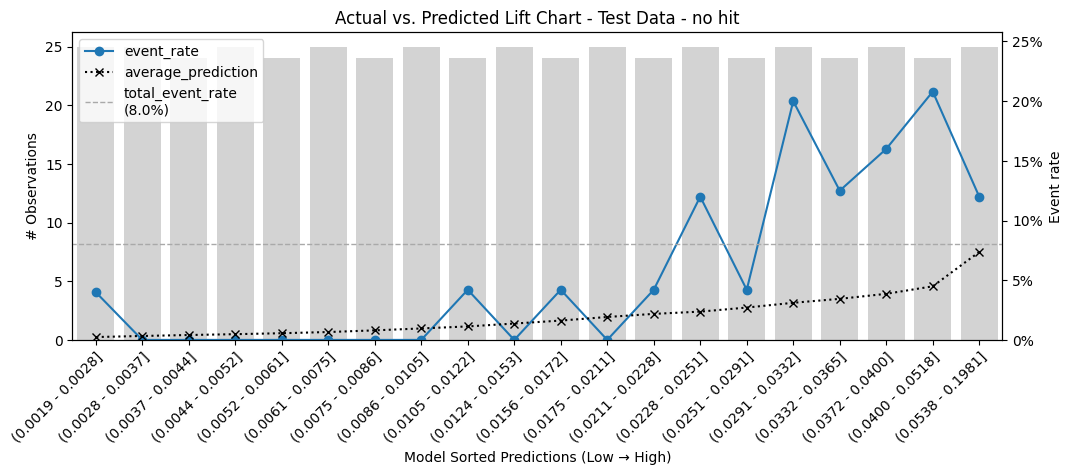

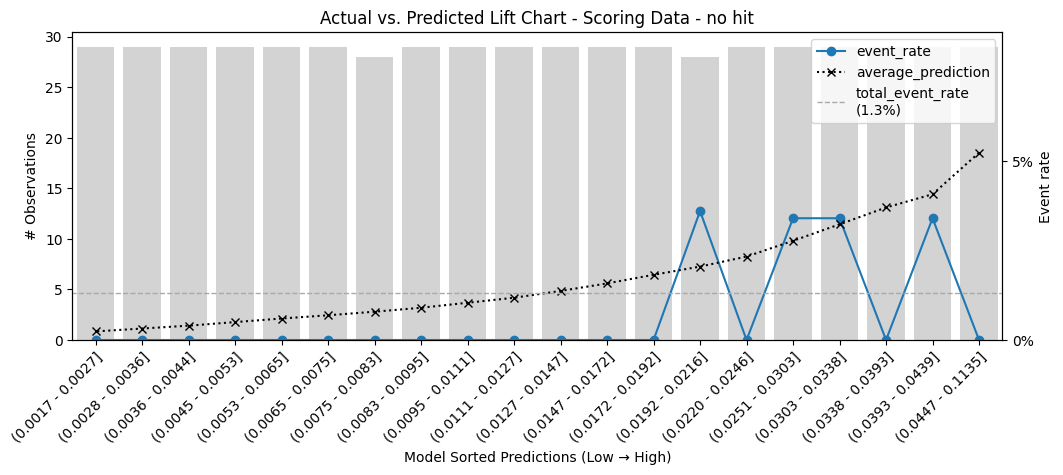

In [19]:

mt.lift_chart_plot('Test Data - no hit', mt.compute_decile_table(
        data_test_scored[data_test_scored['booked']],
        'pd_no_hit',
        'is_bad',
        20,
        'double_no_hit'
), 'PROB_RANGE')


mt.lift_chart_plot('Scoring Data - no hit', mt.compute_decile_table(
        data_scoring_scored[data_scoring_scored['booked']],
        'pd_no_hit',
        'is_bad',
        20,
        'double_no_hit'
), 'PROB_RANGE')

# New Model

In [20]:
# Define the conditions and choices once

conditions = [
    (lambda df: (df['pg_required_c'] == True) & (df['sbfeaccountcount_ln'] >= 1) & (df['sbfehitindex_ln'] >= 2) & (df['fico_score'].notnull())),
    (lambda df: (df['pg_required_c'] == True) & (df['sbfeaccountcount_ln'] >= 1) & (df['sbfehitindex_ln'] >= 2) & (df['fico_score'].isnull())),
    (lambda df: (df['pg_required_c'] == True) & (df['b2bcnt2y_ln'] >= 1) & (df['sbfehitindex_ln'] == 1) & (df['fico_score'].notnull())),
    (lambda df: (df['pg_required_c'] == True) & (df['b2bcnt2y_ln'] >= 1) & (df['sbfehitindex_ln'] == 1) & (df['fico_score'].isnull())),
    (lambda df: (df['pg_required_c'] == True) & ((df['sbfeaccountcount_ln'] < 1) | (df['sbfeaccountcount_ln'].isnull())) & ((df['b2bcnt2y_ln'] < 1) | (df['b2bcnt2y_ln'].isnull())) & ((df['sbfehitindex_ln'] <= 1) | (df['sbfehitindex_ln'].isnull())) & (df['fico_score'].notnull())),
    (lambda df: (df['pg_required_c'] == True) & ((df['sbfeaccountcount_ln'] < 1) | (df['sbfeaccountcount_ln'].isnull())) & ((df['b2bcnt2y_ln'] < 1) | (df['b2bcnt2y_ln'].isnull())) & ((df['sbfehitindex_ln'] <= 1) | (df['sbfehitindex_ln'].isnull())) & (df['fico_score'].isnull())),
    (lambda df: (df['pg_required_c'] == False) & (df['sbfeaccountcount_ln'] >= 1) & (df['sbfehitindex_ln'] >= 2)),
    (lambda df: (df['pg_required_c'] == False) & (df['b2bcnt2y_ln'] >= 1) & (df['sbfehitindex_ln'] == 1)),
    (lambda df: (df['pg_required_c'] == False) & ((df['sbfeaccountcount_ln'] < 1) | (df['sbfeaccountcount_ln'].isnull())) & ((df['b2bcnt2y_ln'] < 1) | (df['b2bcnt2y_ln'].isnull())) & ((df['sbfehitindex_ln'] < 1) | (df['sbfehitindex_ln'].isnull()))),
#     (lambda df: (df['pg_required_c'] == True) & ((df['b2bcnt2y_ln'] < 1) | (df['b2bcnt2y_ln'].isnull())) & (df['sbfehitindex_ln'] == 1) & (df['fico_score'].notnull())), # merged with segment 5
#     (lambda df: (df['pg_required_c'] == True) & ((df['b2bcnt2y_ln'] < 1) | (df['b2bcnt2y_ln'].isnull())) & (df['sbfehitindex_ln'] == 1) & (df['fico_score'].isnull())), # merged with segment 6, no hits
    (lambda df: (df['pg_required_c'] == False) & ((df['b2bcnt2y_ln'] < 1) | (df['b2bcnt2y_ln'].isnull())) & (df['sbfehitindex_ln'] == 1) & (df['fico_score'].notnull())),
    (lambda df: (df['pg_required_c'] == False) & ((df['b2bcnt2y_ln'] < 1) | (df['b2bcnt2y_ln'].isnull())) & (df['sbfehitindex_ln'] == 1) & (df['fico_score'].isnull()))
]

choices = [
    'pg_and_1_plus_sbfe_tradeline_and_fico_hit',
    'pg_and_1_plus_sbfe_tradeline_and_fico_no_hit',
    'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_hit',
    'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_no_hit',
    'pg_and_no_sbfe_tradeline_and_no_sba_tradeline_and_fico_hit', 
    'pg_and_no_sbfe_tradeline_and_no_sba_tradeline_and_fico_no_hit', 
    'no_pg_and_1_plus_sbfe_tradeline',
    'no_pg_and_no_1_plus_sbfe_tradeline_and_1_plus_sba_tradeline',
    'no_pg_no_sbfe_no_sba_no_fico',
#     'pg_and_no_sbfe_tradeline_and_false_1_plus_sba_tradeline_and_fico_hit', ## contradiction between hitindex and b2bcnt
#     'pg_and_no_sbfe_tradeline_and_false_1_plus_sba_tradeline_and_fico_no_hit', ## contradiction between hitindex and b2bcnt
    'no_pg_and_no_sbfe_tradeline_and_false_1_plus_sba_tradeline_and_fico_hit', ## contradiction between hitindex and b2bcnt, how can have fico
    'no_pg_and_no_sbfe_tradeline_and_false_1_plus_sba_tradeline_and_fico_no_hit' ## contradiction between hitindex and b2bcnt
]


# Apply the function to both dataframes
data_dev = mt.apply_risk_grade_path(data_dev, conditions, choices)
data_test = mt.apply_risk_grade_path(data_test, conditions, choices)
data_scoring = mt.apply_risk_grade_path(data_scoring, conditions, choices)
print(len(data_test))
print(len(data_scoring))


CONDITION_PG_SBFE_FICO = {
    "column": "risk_grade_path",
    "allowed_values": ["pg_and_1_plus_sbfe_tradeline_and_fico_hit"],
}
CONDITION_PG_SBFE_NO_FICO = {
    "column": "risk_grade_path",
    "allowed_values": ["pg_and_1_plus_sbfe_tradeline_and_fico_no_hit"],
}
CONDITION_PG_SBA_FICO = {
    "column": "risk_grade_path",
    "allowed_values": ["pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_hit"],
}
CONDITION_PG_SBA_NO_FICO = {
    "column": "risk_grade_path",
    "allowed_values": ["pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_no_hit"],
}
CONDITION_PG_FICO_ONLY = {
    "column": "risk_grade_path",
    "allowed_values": ["pg_and_no_sbfe_tradeline_and_no_sba_tradeline_and_fico_hit"],
}
CONDITION_PG_NO_HITS = {
    "column": "risk_grade_path",
    "allowed_values": ["pg_and_no_sbfe_tradeline_and_no_sba_tradeline_and_fico_no_hit"],
}
CONDITION_NO_PG_SBFE = {
    "column": "risk_grade_path",
    "allowed_values": ["no_pg_and_1_plus_sbfe_tradeline"],
}
CONDITION_NO_PG_SBA = {
    "column": "risk_grade_path",
    "allowed_values": ["no_pg_and_no_1_plus_sbfe_tradeline_and_1_plus_sba_tradeline"],
}
CONDITION_NO_PG_NO_HITS = {
    "column": "risk_grade_path",
    "allowed_values": ["no_pg_no_sbfe_no_sba_no_fico"],
}
# CONDITION_PG_FALSE_SBA_FICO_HIT = {
#     "column": "risk_grade_path",
#     "allowed_values": ["pg_and_no_sbfe_tradeline_and_false_1_plus_sba_tradeline_and_fico_hit"],
# }
# CONDITION_PG_FALSE_SBA_NO_HITS = {
#     "column": "risk_grade_path",
#     "allowed_values": ["pg_and_no_sbfe_tradeline_and_false_1_plus_sba_tradeline_and_fico_no_hit"],
# }
CONDITION_NO_PG_FALSE_SBA_FICO_HIT = {
    "column": "risk_grade_path",
    "allowed_values": ["no_pg_and_no_sbfe_tradeline_and_false_1_plus_sba_tradeline_and_fico_hit"],
}
CONDITION_NO_PG_FALSE_SBA_NO_HITS = {
    "column": "risk_grade_path",
    "allowed_values": ["no_pg_and_no_sbfe_tradeline_and_false_1_plus_sba_tradeline_and_fico_no_hit"],
}



RISK_GRADE_SEGMENTS = {
    "pg_sbfe_ln_and_fico": {
        "condition": CONDITION_PG_SBFE_FICO,
        "model_cols": ["intercept", "ln_score", "fico_score_filled"],
        "train_filter": "booked",
        "core_model_vars": ["fico_score", "ln_score"],
    },  # LN SBFE hit, use blended score of LN and FICO
    "pg_sbfe_ln_only": {
        "condition": CONDITION_PG_SBFE_NO_FICO,
        "model_cols": ["intercept", "ln_score"],
        "train_filter": "booked",
        "core_model_vars": ["ln_score"],
    },  # LN SBFE hit, no FICO, use LN score only
    "pg_sba_ln_and_fico": {
        "condition": CONDITION_PG_SBA_FICO,
        "model_cols": ["intercept", "ln_score", "fico_score_filled"],
        "train_filter": "booked",
        "core_model_vars": ["fico_score", "ln_score"],
    },  # LN SBA hit, use blended score of LN and FICO
    "pg_sba_ln_only": {
        "condition": CONDITION_PG_SBA_NO_FICO,
        "model_cols": ["intercept", "ln_score"],
        "train_filter": "booked",
        "core_model_vars": ["ln_score"],
    },  # LN SBA hit, no FICO, use LN score only
    "pg_fico_only": {
        "condition": CONDITION_PG_FICO_ONLY,
        "model_cols": ["intercept", "fico_score"],
        "train_filter": "booked",
        "core_model_vars": ["fico_score"],
    },  # PG required, only FICO available
    "pg_no_hits": {
        "condition": CONDITION_PG_NO_HITS,
        "model_cols": ["intercept"],  # Intercept only model
        "train_filter": "booked",
        "core_model_vars": [], 
    }, # PG required, no hits, no FICO
    "no_pg_sbfe_ln_only": {
        "condition": CONDITION_NO_PG_SBFE,
        "model_cols": ["intercept", "ln_score"],
        "train_filter": "booked",
        "core_model_vars": ["ln_score"],
    },  # No PG, SBFE hit, use LN score only
    "no_pg_sba_ln_only": {
        "condition": CONDITION_NO_PG_SBA,
        "model_cols": ["intercept", "ln_score"],
        "train_filter": "booked",
        "core_model_vars": ["ln_score"],
    },  # No PG, SBA hit, use LN score only
    "no_pg_no_hits": {
        "condition": CONDITION_NO_PG_NO_HITS,
        "model_cols": ["intercept"], # Intercept only model
        "train_filter": "booked",
        "core_model_vars": [],
    },  # No PG,FICO hit
#     "pg_false_sba_fico_hit": {
#         "condition": CONDITION_PG_FALSE_SBA_FICO_HIT,
#         "model_cols": ["intercept"], # Intercept only model
#         "train_filter": "booked",
#         "core_model_vars": [],
#     },  # PG Hit 1, FICO hit
#     "pg_false_sba_no_hits": {
#         "condition": CONDITION_PG_FALSE_SBA_NO_HITS,
#         "model_cols": ["intercept"], # Intercept only model
#         "train_filter": "booked",
#         "core_model_vars": [],
#     },  # PG Hit 1, no hits
    "no_pg_false_sba_fico_hit": {
        "condition": CONDITION_NO_PG_FALSE_SBA_FICO_HIT,
        "model_cols": ["intercept"], # Intercept only model
        "train_filter": "booked",
        "core_model_vars": [],
    },  # PG Hit 1, FICO hit
    "no_pg_false_sba_no_hits": {
        "condition": CONDITION_NO_PG_FALSE_SBA_NO_HITS,
        "model_cols": ["intercept"], # Intercept only model
        "train_filter": "booked",
        "core_model_vars": [],
    },  # PG Hit 1, no hits
}

NORMALIZE_SCORES = True

11256
16576


## Training Model

In [21]:
data_dev_filtered = mt.risk_grade_estimate_preprocessing(data_dev)

models_dict, normalization_dict = mt.fit_models_for_segments(data_dev_filtered, RISK_GRADE_SEGMENTS, NORMALIZE_SCORES)

print(mt.generate_model_parameters_df(models_dict=models_dict))

data_test_filtered = mt.risk_grade_estimate_preprocessing(data_test)

data_scoring_filtered = mt.risk_grade_estimate_preprocessing(data_scoring)

print(len(data_dev_filtered))

print(data_dev_filtered.risk_grade_path.value_counts())

print(len(data_test_filtered))

print(data_test_filtered.risk_grade_path.value_counts())

print(len(data_scoring_filtered))

print(data_scoring_filtered.risk_grade_path.value_counts())

data_dev_scored = mt.apply_fitted_models_to_data(
    data=data_dev_filtered,
    models_dict=models_dict,
    normalization_dict=normalization_dict,
    RISK_GRADE_SEGMENTS=RISK_GRADE_SEGMENTS,
    NORMALIZE_SCORES = NORMALIZE_SCORES,
)

data_test_scored = mt.apply_fitted_models_to_data(
    data=data_test_filtered,
    models_dict=models_dict,
    normalization_dict=normalization_dict,
    RISK_GRADE_SEGMENTS=RISK_GRADE_SEGMENTS,
    NORMALIZE_SCORES = NORMALIZE_SCORES,
)

data_scoring_scored = mt.apply_fitted_models_to_data(
    data=data_scoring_filtered,
    models_dict=models_dict,
    normalization_dict=normalization_dict,
    RISK_GRADE_SEGMENTS=RISK_GRADE_SEGMENTS,
    NORMALIZE_SCORES = NORMALIZE_SCORES,
)


# Define the risk grade thresholds
new_pd_risk_grade_thresholds = {
    "1a": (0.00, 0.0009),
    "1b": (0.0009, 0.0022),
    "1c": (0.0022, 0.0066),
    "2a": (0.0066, 0.0110),
    "2b": (0.0110, 0.0165),
    "2c": (0.0165, 0.0248),
    "3a": (0.0248, 0.0371),
    "3b": (0.0371, 0.0464),
    "3c": (0.0464, 0.0557),
    "4a": (0.0557, 0.0835),
    "4b": (0.0835, 0.1040),
    "4c": (0.1040, 0.1280),
    "5a": (0.1280, 0.1570),
    "5b": (0.1570, 0.1930),
    "5c": (0.1930, 0.2370),
    "6a": (0.2370, 0.2910),
    "6b": (0.2910, 0.3570),
    "6c": (0.3570, 0.5000),
    "7a": (0.5000, 0.8140),
    "7b": (0.8140, 1.0000),
}

# Define the approval/decline thresholds based on risk grade
approval_thresholds = {
    "1a": True,
    "1b": True,
    "1c": True,
    "2a": True,
    "2b": True,
    "2c": True,
    "3a": True,
    "3b": True,
    "3c": True,
    "4a": False,  # Decline starts here
    "4b": False,
    "4c": False,
    "5a": False,
    "5b": False,
    "5c": False,
    "6a": False,
    "6b": False,
    "6c": False,
    "7a": False,
    "7b": False,
}



Optimization terminated successfully.
         Current function value: 0.086625
         Iterations: 22
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.115558
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.220588
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.257123
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.133259
         Iterations: 17
         Function evaluations: 18
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 0.319412
         Iterations: 7
         Function evaluations: 8
    

#### Checking PG rule

In [139]:
# data_pg_review = data_dev_scored.copy()
# data_pg_review = data_test_scored.copy()
data_pg_review = data_scoring_scored.copy()

# segment = 'pg_and_1_plus_sbfe_tradeline_and_fico_hit'
# segment = 'pg_and_1_plus_sbfe_tradeline_and_fico_no_hit'
# segment = 'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_hit'
# segment = 'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_no_hit'
# segment = 'pg_and_no_sbfe_tradeline_and_no_sba_tradeline_and_fico_hit'
segment = 'pg_and_no_sbfe_tradeline_and_no_sba_tradeline_and_fico_no_hit'


data_pg_review['number_of_trucks_segment'] = np.where(data_pg_review['number_of_trucks_c'].isnull(), 'null', np.where(data_pg_review['number_of_trucks_c'] <= 7, '0-7', '8+'))
data_pg_review['years_in_business_segment'] = np.where(data_pg_review['years_in_business_num_c'].isnull(), 'null', np.where(data_pg_review['years_in_business_num_c'] <= 3, '0-3', '4+'))

grouped_data = data_pg_review.groupby(["risk_grade_path", "pg_required_c", "number_of_trucks_segment", "years_in_business_segment", "booked", "is_bad"]).size().reset_index(name="count")
num_rows_missing_pg_rule = sum(grouped_data[(grouped_data['risk_grade_path'] == segment) & (grouped_data['number_of_trucks_segment'] == '8+') & (grouped_data['years_in_business_segment'] == '4+')]["count"])
print(len(data_pg_review))
print(sum(grouped_data["count"]))
print(sum(grouped_data[(grouped_data['risk_grade_path'] == segment)]["count"]))
print(num_rows_missing_pg_rule)
print(num_rows_missing_pg_rule/sum(grouped_data[(grouped_data['risk_grade_path'] == segment)]["count"]))

grouped_data[grouped_data['risk_grade_path'] == segment]


16576
16576
1679
42
0.02501488981536629


,risk_grade_path,pg_required_c,number_of_trucks_segment,years_in_business_segment,booked,is_bad,count
81,pg_and_no_sbfe_tradeline_and_no_sba_tradeline_...,True,0-7,0-3,False,False,741
82,pg_and_no_sbfe_tradeline_and_no_sba_tradeline_...,True,0-7,0-3,True,False,187
83,pg_and_no_sbfe_tradeline_and_no_sba_tradeline_...,True,0-7,0-3,True,True,11
84,pg_and_no_sbfe_tradeline_and_no_sba_tradeline_...,True,0-7,4+,False,False,423
85,pg_and_no_sbfe_tradeline_and_no_sba_tradeline_...,True,0-7,4+,True,False,197
86,pg_and_no_sbfe_tradeline_and_no_sba_tradeline_...,True,0-7,4+,True,True,11
87,pg_and_no_sbfe_tradeline_and_no_sba_tradeline_...,True,8+,0-3,False,False,50
88,pg_and_no_sbfe_tradeline_and_no_sba_tradeline_...,True,8+,0-3,True,False,17
89,pg_and_no_sbfe_tradeline_and_no_sba_tradeline_...,True,8+,4+,False,False,27
90,pg_and_no_sbfe_tradeline_and_no_sba_tradeline_...,True,8+,4+,True,False,15


In [154]:
# data_pg_review = data_dev_scored.copy()
# data_pg_review = data_test_scored.copy()
data_pg_review = data_scoring_scored.copy()

# segment = 'no_pg_and_1_plus_sbfe_tradeline'
# segment = 'no_pg_and_no_1_plus_sbfe_tradeline_and_1_plus_sba_tradeline'
# segment = 'no_pg_no_sbfe_no_sba_no_fico'
# segment = 'no_pg_and_no_sbfe_tradeline_and_false_1_plus_sba_tradeline_and_fico_hit'
segment = 'no_pg_and_no_sbfe_tradeline_and_false_1_plus_sba_tradeline_and_fico_no_hit'


data_pg_review['number_of_trucks_segment'] = np.where(data_pg_review['number_of_trucks_c'].isnull(), 'null', np.where(data_pg_review['number_of_trucks_c'] <= 7, '0-7', '8+'))
data_pg_review['years_in_business_segment'] = np.where(data_pg_review['years_in_business_num_c'].isnull(), 'null', np.where(data_pg_review['years_in_business_num_c'] <= 3, '0-3', '4+'))

grouped_data = data_pg_review.groupby(["risk_grade_path", "pg_required_c", "number_of_trucks_segment", "years_in_business_segment", "booked", "is_bad"]).size().reset_index(name="count")
num_rows_missing_pg_rule = sum(grouped_data[(grouped_data['risk_grade_path'] == segment) & ((grouped_data['number_of_trucks_segment'] == '0-7') | (grouped_data['years_in_business_segment'] == '0-3'))]["count"])
print(len(data_pg_review))
print(sum(grouped_data["count"]))
print(sum(grouped_data[(grouped_data['risk_grade_path'] == segment)]["count"]))
print(num_rows_missing_pg_rule)
print(num_rows_missing_pg_rule/sum(grouped_data[(grouped_data['risk_grade_path'] == segment)]["count"]))

grouped_data[grouped_data['risk_grade_path'] == segment]


16576
16576
62
11
0.1774193548387097


,risk_grade_path,pg_required_c,number_of_trucks_segment,years_in_business_segment,booked,is_bad,count
19,no_pg_and_no_sbfe_tradeline_and_false_1_plus_s...,False,0-7,0-3,False,False,6
20,no_pg_and_no_sbfe_tradeline_and_false_1_plus_s...,False,0-7,0-3,True,False,3
21,no_pg_and_no_sbfe_tradeline_and_false_1_plus_s...,False,0-7,4+,False,False,1
22,no_pg_and_no_sbfe_tradeline_and_false_1_plus_s...,False,0-7,4+,True,False,1
23,no_pg_and_no_sbfe_tradeline_and_false_1_plus_s...,False,8+,4+,False,False,33
24,no_pg_and_no_sbfe_tradeline_and_false_1_plus_s...,False,8+,4+,True,False,17
25,no_pg_and_no_sbfe_tradeline_and_false_1_plus_s...,False,8+,4+,True,True,1


In [22]:

# Training: Calculate segment statistics with approval/decline thresholds
segment_stats_df = mt.calculate_segment_statistics_with_approval(
    data=data_dev_scored,
    RISK_GRADE_SEGMENTS=RISK_GRADE_SEGMENTS,
    risk_grade_thresholds=new_pd_risk_grade_thresholds,
    approval_thresholds=approval_thresholds,
)

# # Display the results
# print(segment_stats_df)


# Test: Calculate segment statistics with approval/decline thresholds
segment_stats_df = mt.calculate_segment_statistics_with_approval(
    data=data_test_scored,
    RISK_GRADE_SEGMENTS=RISK_GRADE_SEGMENTS,
    risk_grade_thresholds=new_pd_risk_grade_thresholds,
    approval_thresholds=approval_thresholds,
)

# # Display the results
# print(segment_stats_df)

# Current: 
segment_stats_df = mt.calculate_segment_statistics_with_approval(
    data=data_scoring_scored,
    RISK_GRADE_SEGMENTS=RISK_GRADE_SEGMENTS,
    risk_grade_thresholds=new_pd_risk_grade_thresholds,
    approval_thresholds=approval_thresholds,
)

# # Display the results
# print(segment_stats_df)

segment_stats_df

,segment_name,total_rows,num_booked,num_non_booked,booked_is_bad,predicted_booked,predicted_booked_is_bad,predicted_declined,min_number_of_trucks,max_number_of_trucks,avg_number_of_trucks,min_years_in_business,max_years_in_business,avg_years_in_business
0,pg_sbfe_ln_and_fico,3464,2446,1018,17,2737,17,727,0.0,80.0,2.264723,0.0,106.0,5.305139
1,pg_sbfe_ln_only,722,491,231,16,611,16,111,0.0,61.0,2.621884,0.0,95.0,6.325485
2,pg_sba_ln_and_fico,627,193,434,2,204,2,423,1.0,137.0,2.661882,0.0,77.0,3.526316
3,pg_sba_ln_only,159,34,125,1,0,0,159,0.0,37.0,2.622642,0.0,40.0,4.270440
4,pg_fico_only,9169,5078,4091,54,5588,46,3581,0.0,85.0,2.000327,0.0,122.0,3.193696
5,pg_no_hits,1679,438,1241,22,0,0,1679,0.0,72.0,2.961882,0.0,109.0,4.678976
6,no_pg_sbfe_ln_only,408,335,73,3,380,3,27,1.0,150.0,16.245098,0.0,85.0,13.421569
7,no_pg_sba_ln_only,28,7,21,0,9,0,19,1.0,75.0,13.500000,2.0,22.0,8.250000
8,no_pg_no_hits,234,157,77,10,234,10,0,0.0,100.0,13.863248,0.0,71.0,9.260684
9,no_pg_false_sba_fico_hit,24,11,13,0,24,0,0,1.0,8.0,1.958333,0.0,7.0,2.291667


In [23]:
data_scoring_filtered[data_scoring_filtered['risk_grade_path'] == 'nan'].head()

,application_number,ar_id,booked,decision_date,number_of_trucks_c,program_group,product_type_c,fraud_flag_c,existing_exposure_check_c,credit_line_requested_c,...,sbfeaccountcount_ln,sbfehitindex_ln,years_in_business_num_c,risk_grade_path,has_fico,intercept,no_fico,fico_score_filled,ln_score_filled,no_ln


In [24]:
normalization_dict

{'pg_sbfe_ln_and_fico': {'ln_score': {'std': 54.73682089179337,
   'mean': 691.5942440210782},
  'fico_score_filled': {'std': 63.85355451455604, 'mean': 710.1576813944062}},
 'pg_sbfe_ln_only': {'ln_score': {'std': 66.71087090325348,
   'mean': 683.9196787148594}},
 'pg_sba_ln_and_fico': {'ln_score': {'std': 45.731810666248805,
   'mean': 685.5669515669516},
  'fico_score_filled': {'std': 72.54145953802362, 'mean': 647.5356125356126}},
 'pg_sba_ln_only': {'ln_score': {'std': 49.14940760198726,
   'mean': 674.6178861788618}},
 'pg_fico_only': {'fico_score': {'std': 74.20708340100364,
   'mean': 678.3740901133327}},
 'pg_no_hits': {},
 'no_pg_sbfe_ln_only': {'ln_score': {'std': 62.03816399637875,
   'mean': 695.6245081506464}},
 'no_pg_sba_ln_only': {'ln_score': {'std': 50.57822613372447,
   'mean': 682.0095124851367}},
 'no_pg_no_hits': {},
 'no_pg_false_sba_fico_hit': {},
 'no_pg_false_sba_no_hits': {}}

In [25]:



parameters = pd.DataFrame(mt.generate_model_parameters_df(models_dict=models_dict))

fico_scores = [600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840, 850]
ln_scores = [500, 550, 600, 650, 700, 750, 800, 850, 900]


for segment in parameters['segment'].unique():
    params = parameters[parameters['segment'] == segment].iloc[0].to_dict()
    predictions = None

    # Normalization inside the loop
    normalized_fico_scores = fico_scores
    normalized_fico_scores_filled = fico_scores
    normalized_ln_scores = ln_scores

    if normalization_dict.get(segment) is not None:

        if "fico_score" in normalization_dict[segment]:
            mean = normalization_dict[segment]["fico_score"]["mean"]
            std = normalization_dict[segment]["fico_score"]["std"]
            if std != 0:
                normalized_fico_scores = [(score - mean) / std for score in fico_scores]

        if "fico_score_filled" in normalization_dict[segment]: # Normalize filled scores separately
            mean = normalization_dict[segment]["fico_score_filled"]["mean"]
            std = normalization_dict[segment]["fico_score_filled"]["std"]
            if std != 0:
                normalized_fico_scores_filled = [(score - mean) / std for score in fico_scores]

        if "ln_score" in normalization_dict[segment]:
            mean = normalization_dict[segment]["ln_score"]["mean"]
            std = normalization_dict[segment]["ln_score"]["std"]
            if std != 0:
                normalized_ln_scores = [(score - mean) / std for score in ln_scores]


    if pd.isna(params['ln_score_z']) and pd.isna(params['fico_score_filled_z']):  # Constant only model
        predictions = mt.predict_with_model(pd.DataFrame(), parameters, segment)
        print(f"Predictions for segment: {segment}")
        print(f"Constant prediction: {predictions}")


    elif pd.isna(params['fico_score_filled_z']):  # ln_score only
        predictions = mt.predict_with_model(pd.DataFrame({'ln_score_z': normalized_ln_scores}), parameters, segment)
        print(f"Predictions for segment: {segment}")
        for i, prediction in enumerate(predictions):
            print(f"{normalized_ln_scores[i]}: {prediction}")  # Use normalized ln_scores



    elif pd.isna(params['ln_score_z']):  # fico_score only
        fico_score_col = 'fico_score_z' if segment == 'pg_fico_only' else 'fico_score_filled_z' # Make sure column names align in parameters and normalization_dict
        predictions = mt.predict_with_model(pd.DataFrame({fico_score_col: normalized_fico_scores}), parameters, segment)
        print(f"Predictions for segment: {segment}")
        print(predictions)



    else:  # Both ln_score and fico_score
        predictions = pd.DataFrame(index=normalized_fico_scores_filled, columns=normalized_ln_scores)
        for fico in normalized_fico_scores_filled:
            for ln in normalized_ln_scores:
                fico_col = 'fico_score_z' if segment == 'pg_fico_only' else 'fico_score_filled_z'
                data = {fico_col: [fico], 'ln_score_z': [ln]}
                prediction = mt.predict_with_model(pd.DataFrame(data), parameters, segment)
                predictions.loc[fico, ln] = prediction.iloc[0]
                
        predictions.index = list(zip(fico_scores, normalized_fico_scores_filled))
        predictions.columns = list(zip(ln_scores, normalized_ln_scores))

        print(f"Predictions for segment: {segment}")
        print(predictions)


    # Risk Grade Matrix/Series Creation
    if predictions is not None:
        if isinstance(predictions, pd.Series):
            risk_grades = predictions.apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))
            print(f"\nRisk Grade Series for segment: {segment}")
            print(risk_grades)
        elif isinstance(predictions, pd.DataFrame):
            risk_grade_matrix = predictions.applymap(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))
            print(f"\nRisk Grade Matrix for segment: {segment}")
            print(risk_grade_matrix)

        print("-" * 50)

Predictions for segment: pg_sbfe_ln_and_fico
                           (500, -3.5002808146244337)  \
(600, -1.725161304360819)                    0.569221   
(620, -1.4119445985399894)                   0.488349   
(640, -1.09872789271916)                     0.408083   
(660, -0.7855111868983303)                   0.332437   
(680, -0.4722944810775008)                   0.264547   
(700, -0.1590777752566713)                   0.206238   
(720, 0.15413893056415823)                    0.15802   
(740, 0.4673556363849878)                    0.119379   
(760, 0.7805723422058173)                    0.089187   
(780, 1.0937890480266468)                    0.066057   
(800, 1.4070057538474763)                    0.048606   
(820, 1.720222459668306)                      0.03559   
(840, 2.0334391654891353)                    0.025964   
(850, 2.1900475183995503)                    0.022153   

                           (550, -2.5868189221472906)  \
(600, -1.725161304360819)                 

In [26]:
data_scoring_scored.tail()

,application_number,ar_id,booked,decision_date,number_of_trucks_c,program_group,product_type_c,fraud_flag_c,existing_exposure_check_c,credit_line_requested_c,...,pd_pg_sba_ln_and_fico,pd_pg_sba_ln_only,fico_score_z,pd_pg_fico_only,pd_pg_no_hits,pd_no_pg_sbfe_ln_only,pd_no_pg_sba_ln_only,pd_no_pg_no_hits,pd_no_pg_false_sba_fico_hit,pd_no_pg_false_sba_no_hits
290571,713618,3770002408108,True,2024-06-03,12.0,RTS Fleet One,OTR,False,Passed,42000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.069054
302905,744781,3770002413926,True,2024-10-15,3.0,Edge,OTR - LLC,False,Passed,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.069054
314085,750970,3770002414791,True,2024-11-06,30.0,NASTC - OTR,OTR,False,Passed,51000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.069054
317683,730140,-1,False,2024-08-12,20.0,XPO Logistics,OTR,False,Passed,70000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.069054
318673,697220,3770002406193,True,2024-04-25,24.0,RTS Fleet One,OTR,False,Passed,40800.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.069054


## Lift Charts

#### pd_pg_sbfe_ln_and_fico

g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


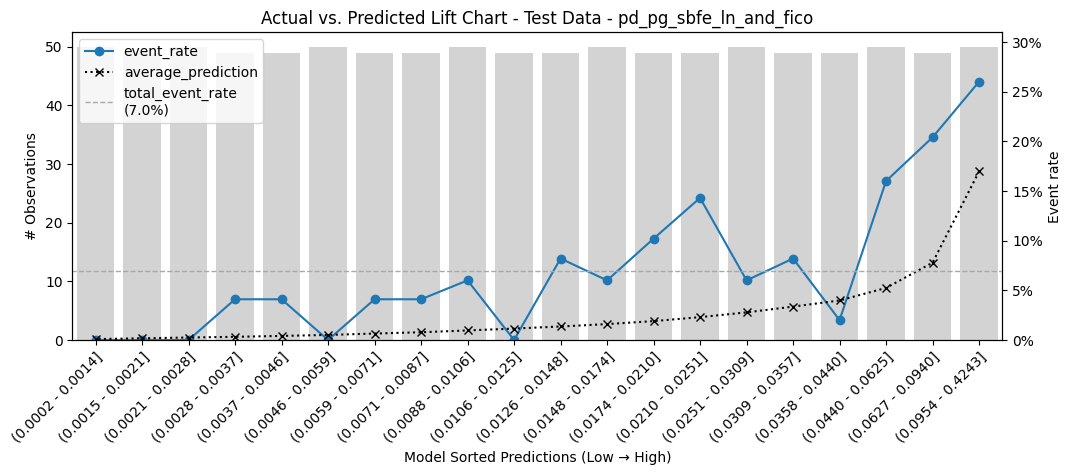

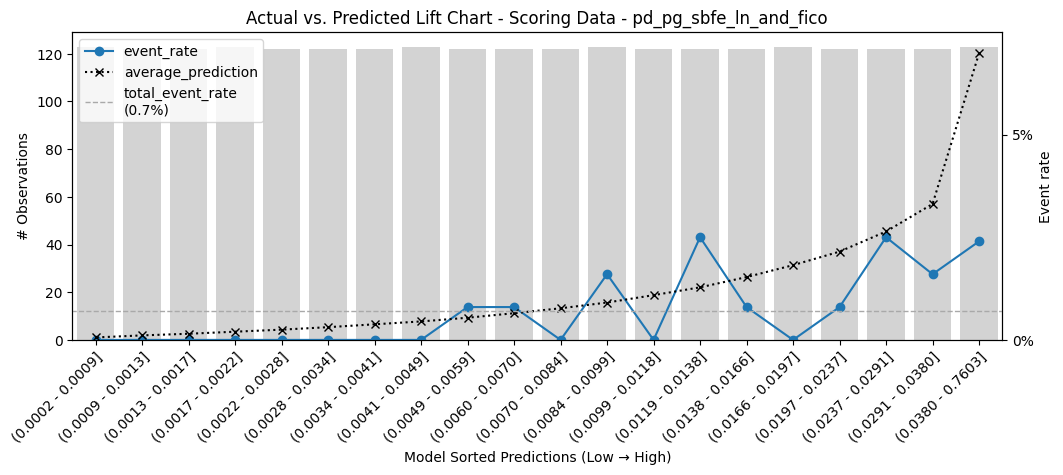

In [27]:


mt.lift_chart_plot('Test Data - pd_pg_sbfe_ln_and_fico', mt.compute_decile_table(
        data_test_scored[data_test_scored['booked']],
        'pd_pg_sbfe_ln_and_fico',
        'is_bad',
        20,
        'pg_and_1_plus_sbfe_tradeline_and_fico_hit'
), 'PROB_RANGE')


mt.lift_chart_plot('Scoring Data - pd_pg_sbfe_ln_and_fico', mt.compute_decile_table(
        data_scoring_scored[data_scoring_scored['booked']],
        'pd_pg_sbfe_ln_and_fico',
        'is_bad',
        20,
        'pg_and_1_plus_sbfe_tradeline_and_fico_hit'
), 'PROB_RANGE')






g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


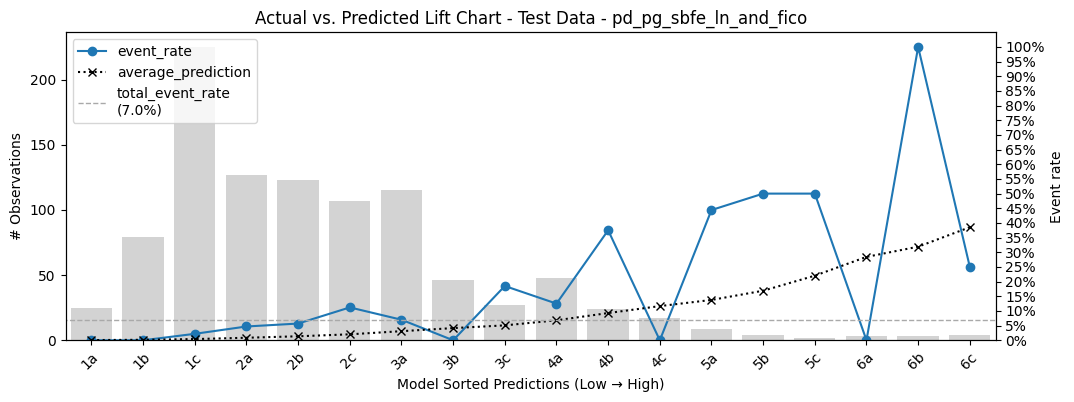

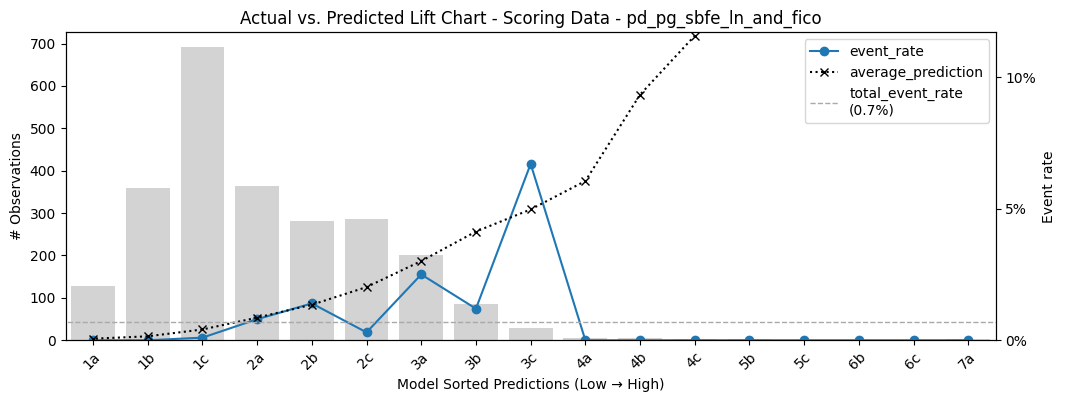

In [28]:

data = data_test_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_1_plus_sbfe_tradeline_and_fico_hit')]['pd_pg_sbfe_ln_and_fico'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Test Data - pd_pg_sbfe_ln_and_fico',mt.compute_risk_grade_table(
        data[data['booked']],
        'pd_pg_sbfe_ln_and_fico',
        'is_bad',
        20,
        'pg_and_1_plus_sbfe_tradeline_and_fico_hit',
        'risk_grades'
), 'risk_grades')




data = data_scoring_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_1_plus_sbfe_tradeline_and_fico_hit')]['pd_pg_sbfe_ln_and_fico'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Scoring Data - pd_pg_sbfe_ln_and_fico',mt.compute_risk_grade_table(
        data[data['booked']],
        'pd_pg_sbfe_ln_and_fico',
        'is_bad',
        20,
        'pg_and_1_plus_sbfe_tradeline_and_fico_hit',
        'risk_grades'
), 'risk_grades')

In [29]:
data = data_dev_scored.copy()
data = data[(data['risk_grade_path'] == 'pg_and_1_plus_sbfe_tradeline_and_fico_hit')]
print(len(data))

# Define fico score bands and ln_score ranges
fico_bands = [580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840]
fico_ranges = list(zip(fico_bands[:-1], fico_bands[1:]))
fico_ranges.append((fico_bands[-1], 900))
ln_bands = [500, 550, 600, 650, 700, 750, 800, 850, 900]
ln_ranges = list(zip(ln_bands[:-1], ln_bands[1:]))
ln_ranges.append((ln_bands[-1], 900))

# Create an empty matrix to store results
results_matrix = pd.DataFrame(index=fico_ranges, columns=ln_ranges)  # Use ln_ranges directly for columns
results_matrix = results_matrix.fillna('')
total_test = 0
# Iterate through fico bands and ln_score ranges
for i in range(len(fico_ranges)):
    for j in range(len(ln_ranges)):  # Iterate through all ln_ranges
        fico_lower = fico_ranges[i][0]
        fico_upper = fico_ranges[i][1]
        ln_lower = ln_ranges[j][0]
        ln_upper = ln_ranges[j][1]

        filtered_df = data[
            (data['fico_score'] >= fico_lower) &
            (data['fico_score'] < fico_upper) &
            (data['ln_score'] >= ln_lower) &
            (data['ln_score'] < ln_upper)
        ]

        total_rows = len(filtered_df)
        if total_rows > 0:
            total_test += total_rows
            booked_rows = filtered_df['booked'].sum()
            booked_rate = (booked_rows / total_rows) * 100
            results_matrix.iloc[i, j] = f"{total_rows} ({booked_rate:.1f}%)"
        else:
            results_matrix.iloc[i, j] = "0 (0.0%)"

# Display the results matrix
print(total_test)
results_matrix

2467
2370


,"(500, 550)","(550, 600)","(600, 650)","(650, 700)","(700, 750)","(750, 800)","(800, 850)","(850, 900)","(900, 900)"
"(580, 600)",1 (0.0%),5 (20.0%),12 (0.0%),15 (0.0%),8 (0.0%),1 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
"(600, 620)",0 (0.0%),6 (0.0%),17 (0.0%),18 (0.0%),13 (0.0%),1 (0.0%),1 (0.0%),0 (0.0%),0 (0.0%)
"(620, 640)",2 (0.0%),7 (57.1%),23 (69.6%),48 (68.8%),27 (66.7%),7 (28.6%),0 (0.0%),0 (0.0%),0 (0.0%)
"(640, 660)",5 (60.0%),13 (92.3%),36 (83.3%),75 (82.7%),58 (84.5%),4 (75.0%),1 (100.0%),0 (0.0%),0 (0.0%)
"(660, 680)",2 (100.0%),5 (100.0%),44 (86.4%),68 (85.3%),73 (94.5%),16 (87.5%),1 (100.0%),0 (0.0%),0 (0.0%)
"(680, 700)",1 (100.0%),7 (85.7%),55 (85.5%),113 (89.4%),70 (88.6%),25 (88.0%),0 (0.0%),0 (0.0%),0 (0.0%)
"(700, 720)",1 (100.0%),8 (100.0%),53 (92.5%),117 (86.3%),91 (87.9%),26 (92.3%),3 (66.7%),0 (0.0%),0 (0.0%)
"(720, 740)",2 (100.0%),6 (100.0%),42 (83.3%),97 (87.6%),99 (83.8%),31 (96.8%),2 (100.0%),0 (0.0%),0 (0.0%)
"(740, 760)",2 (100.0%),8 (100.0%),34 (88.2%),103 (88.3%),114 (85.1%),51 (92.2%),5 (100.0%),0 (0.0%),0 (0.0%)
"(760, 780)",0 (0.0%),4 (100.0%),24 (91.7%),96 (88.5%),101 (90.1%),56 (92.9%),7 (85.7%),0 (0.0%),0 (0.0%)


In [30]:
data = data_test_scored.copy()
data = data[(data['risk_grade_path'] == 'pg_and_1_plus_sbfe_tradeline_and_fico_hit')]


# Define fico score bands and ln_score ranges
fico_bands = [580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840]
fico_ranges = list(zip(fico_bands[:-1], fico_bands[1:]))
fico_ranges.append((fico_bands[-1], 900))
ln_bands = [500, 550, 600, 650, 700, 750, 800, 850, 900]
ln_ranges = list(zip(ln_bands[:-1], ln_bands[1:]))
ln_ranges.append((ln_bands[-1], 900))

# Create an empty matrix to store results
results_matrix = pd.DataFrame(index=fico_ranges, columns=ln_ranges)  # Use ln_ranges directly for columns
results_matrix = results_matrix.fillna('')

# Iterate through fico bands and ln_score ranges
for i in range(len(fico_ranges)):
    for j in range(len(ln_ranges)):  # Iterate through all ln_ranges
        fico_lower = fico_ranges[i][0]
        fico_upper = fico_ranges[i][1]
        ln_lower = ln_ranges[j][0]
        ln_upper = ln_ranges[j][1]

        filtered_df = data[
            (data['fico_score'] >= fico_lower) &
            (data['fico_score'] < fico_upper) &
            (data['ln_score'] >= ln_lower) &
            (data['ln_score'] < ln_upper)
        ]

        total_rows = len(filtered_df)
        if total_rows > 0:
            booked_rows = filtered_df['booked'].sum()
            booked_rate = (booked_rows / total_rows) * 100
            results_matrix.iloc[i, j] = f"{total_rows} ({booked_rate:.1f}%)"
        else:
            results_matrix.iloc[i, j] = "0 (0.0%)"

# Display the results matrix
results_matrix

,"(500, 550)","(550, 600)","(600, 650)","(650, 700)","(700, 750)","(750, 800)","(800, 850)","(850, 900)","(900, 900)"
"(580, 600)",6 (0.0%),2 (0.0%),5 (0.0%),13 (7.7%),7 (0.0%),2 (50.0%),0 (0.0%),0 (0.0%),0 (0.0%)
"(600, 620)",3 (0.0%),3 (0.0%),9 (0.0%),15 (6.7%),11 (0.0%),1 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
"(620, 640)",2 (50.0%),4 (25.0%),23 (69.6%),35 (54.3%),21 (66.7%),9 (77.8%),1 (0.0%),0 (0.0%),0 (0.0%)
"(640, 660)",8 (75.0%),7 (85.7%),24 (79.2%),40 (77.5%),24 (58.3%),3 (66.7%),1 (0.0%),0 (0.0%),0 (0.0%)
"(660, 680)",4 (100.0%),10 (70.0%),27 (88.9%),62 (77.4%),32 (96.9%),8 (62.5%),3 (100.0%),0 (0.0%),0 (0.0%)
"(680, 700)",0 (0.0%),10 (90.0%),27 (74.1%),58 (84.5%),46 (91.3%),4 (100.0%),1 (100.0%),0 (0.0%),0 (0.0%)
"(700, 720)",4 (50.0%),3 (100.0%),17 (94.1%),54 (92.6%),45 (86.7%),16 (87.5%),2 (100.0%),0 (0.0%),0 (0.0%)
"(720, 740)",1 (100.0%),6 (100.0%),22 (72.7%),40 (80.0%),47 (93.6%),13 (84.6%),0 (0.0%),0 (0.0%),0 (0.0%)
"(740, 760)",1 (100.0%),8 (87.5%),11 (81.8%),48 (95.8%),50 (90.0%),14 (85.7%),2 (100.0%),1 (100.0%),0 (0.0%)
"(760, 780)",2 (100.0%),5 (80.0%),13 (92.3%),29 (89.7%),44 (93.2%),26 (88.5%),1 (100.0%),0 (0.0%),0 (0.0%)


In [31]:
data = data_scoring_scored.copy()
data = data[(data['risk_grade_path'] == 'pg_and_1_plus_sbfe_tradeline_and_fico_hit')]


# Define fico score bands and ln_score ranges
fico_bands = [580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840]
fico_ranges = list(zip(fico_bands[:-1], fico_bands[1:]))
fico_ranges.append((fico_bands[-1], 900))
ln_bands = [500, 550, 600, 650, 700, 750, 800, 850, 900]
ln_ranges = list(zip(ln_bands[:-1], ln_bands[1:]))
ln_ranges.append((ln_bands[-1], 900))

# Create an empty matrix to store results
results_matrix = pd.DataFrame(index=fico_ranges, columns=ln_ranges)  # Use ln_ranges directly for columns
results_matrix = results_matrix.fillna('')

# Iterate through fico bands and ln_score ranges
for i in range(len(fico_ranges)):
    for j in range(len(ln_ranges)):  # Iterate through all ln_ranges
        fico_lower = fico_ranges[i][0]
        fico_upper = fico_ranges[i][1]
        ln_lower = ln_ranges[j][0]
        ln_upper = ln_ranges[j][1]

        filtered_df = data[
            (data['fico_score'] >= fico_lower) &
            (data['fico_score'] < fico_upper) &
            (data['ln_score'] >= ln_lower) &
            (data['ln_score'] < ln_upper)
        ]

        total_rows = len(filtered_df)
        if total_rows > 0:
            booked_rows = filtered_df['booked'].sum()
            booked_rate = (booked_rows / total_rows) * 100
            results_matrix.iloc[i, j] = f"{total_rows} ({booked_rate:.1f}%)"
        else:
            results_matrix.iloc[i, j] = "0 (0.0%)"

# Display the results matrix
results_matrix

,"(500, 550)","(550, 600)","(600, 650)","(650, 700)","(700, 750)","(750, 800)","(800, 850)","(850, 900)","(900, 900)"
"(580, 600)",3 (0.0%),13 (0.0%),20 (0.0%),29 (0.0%),14 (0.0%),7 (14.3%),0 (0.0%),0 (0.0%),0 (0.0%)
"(600, 620)",4 (0.0%),11 (0.0%),29 (3.4%),26 (3.8%),30 (10.0%),7 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
"(620, 640)",6 (0.0%),13 (7.7%),28 (3.6%),51 (33.3%),47 (70.2%),13 (76.9%),0 (0.0%),0 (0.0%),0 (0.0%)
"(640, 660)",1 (0.0%),9 (0.0%),31 (3.2%),81 (70.4%),63 (93.7%),14 (85.7%),0 (0.0%),0 (0.0%),0 (0.0%)
"(660, 680)",3 (0.0%),11 (0.0%),41 (26.8%),104 (89.4%),90 (91.1%),33 (100.0%),3 (100.0%),0 (0.0%),0 (0.0%)
"(680, 700)",4 (0.0%),6 (0.0%),48 (64.6%),113 (93.8%),113 (88.5%),42 (88.1%),5 (100.0%),1 (0.0%),0 (0.0%)
"(700, 720)",1 (0.0%),4 (0.0%),38 (78.9%),119 (93.3%),129 (92.2%),44 (88.6%),4 (75.0%),0 (0.0%),0 (0.0%)
"(720, 740)",1 (0.0%),7 (14.3%),38 (86.8%),106 (90.6%),112 (93.8%),58 (87.9%),5 (100.0%),0 (0.0%),0 (0.0%)
"(740, 760)",1 (100.0%),5 (0.0%),22 (81.8%),94 (90.4%),153 (93.5%),97 (94.8%),5 (80.0%),0 (0.0%),0 (0.0%)
"(760, 780)",1 (0.0%),1 (0.0%),26 (84.6%),84 (95.2%),118 (93.2%),103 (91.3%),16 (100.0%),0 (0.0%),0 (0.0%)


#### pd_pg_sbfe_ln_only

g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


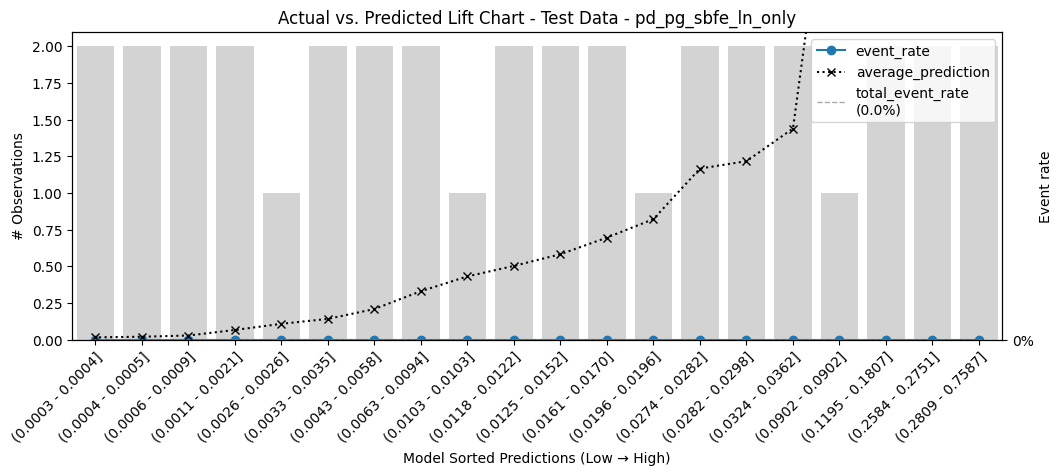

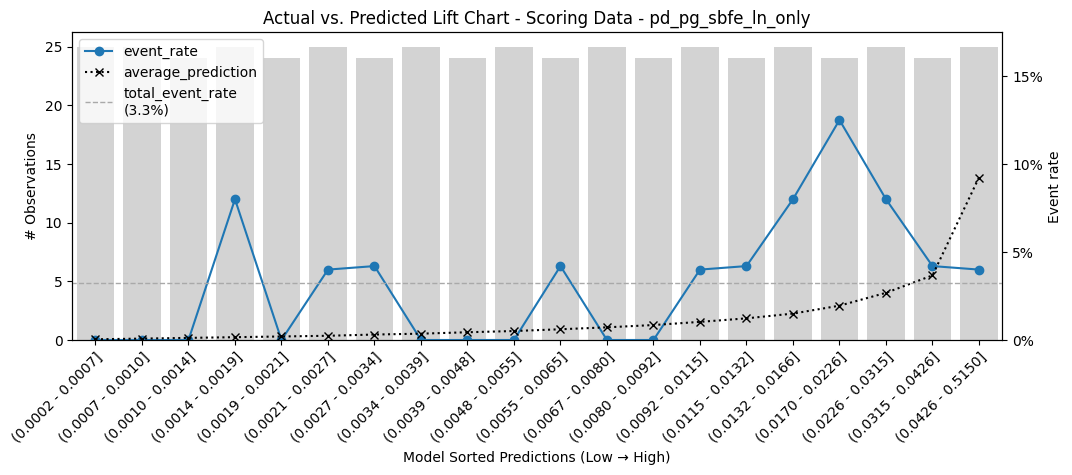

In [32]:

mt.lift_chart_plot('Test Data - pd_pg_sbfe_ln_only', mt.compute_decile_table(
        data_test_scored[data_test_scored['booked']],
        'pd_pg_sbfe_ln_only',
        'is_bad',
        20,
        'pg_and_1_plus_sbfe_tradeline_and_fico_no_hit'
), 'PROB_RANGE')


mt.lift_chart_plot('Scoring Data - pd_pg_sbfe_ln_only', mt.compute_decile_table(
        data_scoring_scored[data_scoring_scored['booked']],
        'pd_pg_sbfe_ln_only',
        'is_bad',
        20,
        'pg_and_1_plus_sbfe_tradeline_and_fico_no_hit'
), 'PROB_RANGE')



g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


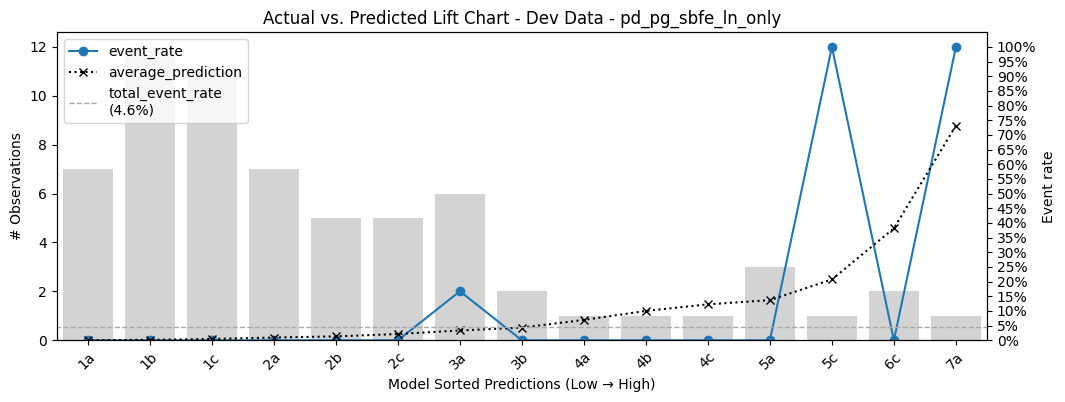

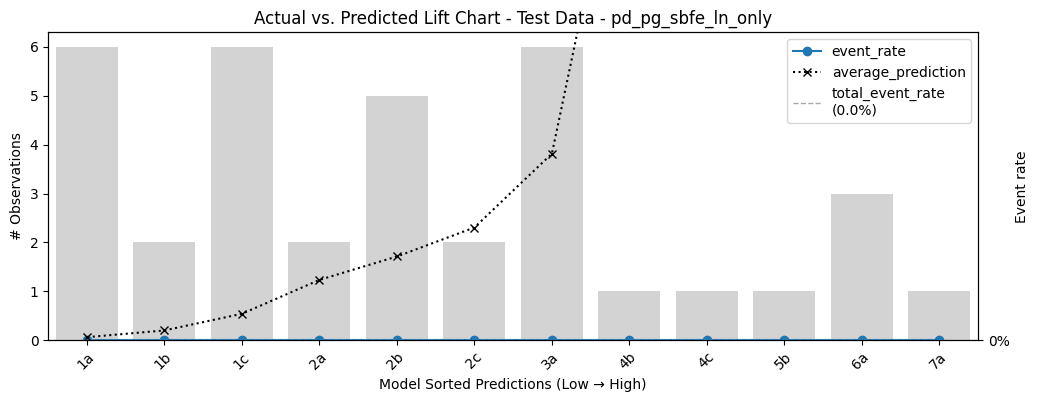

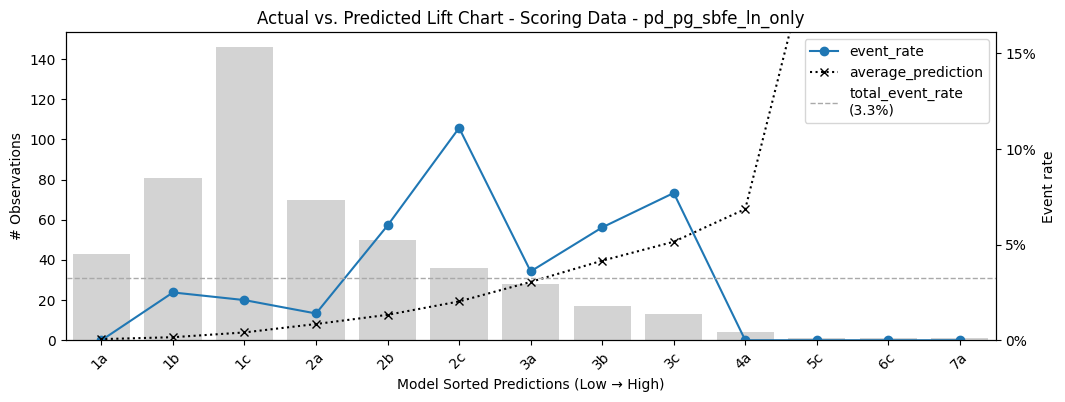

In [33]:

data = data_dev_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_1_plus_sbfe_tradeline_and_fico_no_hit')]['pd_pg_sbfe_ln_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Dev Data - pd_pg_sbfe_ln_only',mt.compute_risk_grade_table(
        data[data['booked']],
        'pd_pg_sbfe_ln_only',
        'is_bad',
        20,
        'pg_and_1_plus_sbfe_tradeline_and_fico_no_hit',
        'risk_grades'
), 'risk_grades')



data = data_test_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_1_plus_sbfe_tradeline_and_fico_no_hit')]['pd_pg_sbfe_ln_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Test Data - pd_pg_sbfe_ln_only',mt.compute_risk_grade_table(
        data[data['booked']],
        'pd_pg_sbfe_ln_only',
        'is_bad',
        20,
        'pg_and_1_plus_sbfe_tradeline_and_fico_no_hit',
        'risk_grades'
), 'risk_grades')




data = data_scoring_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_1_plus_sbfe_tradeline_and_fico_no_hit')]['pd_pg_sbfe_ln_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Scoring Data - pd_pg_sbfe_ln_only',mt.compute_risk_grade_table(
        data[data['booked']],
        'pd_pg_sbfe_ln_only',
        'is_bad',
        20,
        'pg_and_1_plus_sbfe_tradeline_and_fico_no_hit',
        'risk_grades'
), 'risk_grades')

In [34]:
data = data_dev_scored.copy()
data = data[(data['risk_grade_path'] == 'pg_and_1_plus_sbfe_tradeline_and_fico_no_hit')]


# Define fico score bands and ln_score ranges
ln_bands = [500, 550, 600, 650, 700, 750, 800, 850, 900]
ln_ranges = list(zip(ln_bands[:-1], ln_bands[1:]))
ln_ranges.append((ln_bands[-1], 900))


# Create an empty matrix to store results
results_matrix = pd.DataFrame(index=ln_ranges)
results_matrix['counts'] = ''
results_matrix = results_matrix.fillna('')

# Iterate through fico bands and ln_score ranges
for i in range(len(ln_ranges)):
    ln_lower = ln_ranges[i][0]
    ln_upper = ln_ranges[i][1]

    filtered_df = data[
        (data['ln_score'] >= ln_lower) &
        (data['ln_score'] < ln_upper)
    ]

    total_rows = len(filtered_df)
    if total_rows > 0:
        booked_rows = filtered_df['booked'].sum()
        booked_rate = (booked_rows / total_rows) * 100
        results_matrix['counts'].iloc[i] = f"{total_rows} ({booked_rate:.1f}%)"
    else:
        results_matrix['counts'].iloc[i] = "0 (0.0%)"

# Display the results matrix
results_matrix

,counts
"(500, 550)",12 (8.3%)
"(550, 600)",10 (30.0%)
"(600, 650)",40 (17.5%)
"(650, 700)",83 (21.7%)
"(700, 750)",64 (25.0%)
"(750, 800)",35 (45.7%)
"(800, 850)",4 (100.0%)
"(850, 900)",1 (0.0%)
"(900, 900)",0 (0.0%)


In [35]:
data = data_test_scored.copy()
data = data[(data['risk_grade_path'] == 'pg_and_1_plus_sbfe_tradeline_and_fico_no_hit')]


# Define fico score bands and ln_score ranges
ln_bands = [500, 550, 600, 650, 700, 750, 800, 850, 900]
ln_ranges = list(zip(ln_bands[:-1], ln_bands[1:]))
ln_ranges.append((ln_bands[-1], 900))


# Create an empty matrix to store results
results_matrix = pd.DataFrame(index=ln_ranges)
results_matrix['counts'] = ''
results_matrix = results_matrix.fillna('')

# Iterate through fico bands and ln_score ranges
for i in range(len(ln_ranges)):
    ln_lower = ln_ranges[i][0]
    ln_upper = ln_ranges[i][1]

    filtered_df = data[
        (data['ln_score'] >= ln_lower) &
        (data['ln_score'] < ln_upper)
    ]

    total_rows = len(filtered_df)
    if total_rows > 0:
        booked_rows = filtered_df['booked'].sum()
        booked_rate = (booked_rows / total_rows) * 100
        results_matrix['counts'].iloc[i] = f"{total_rows} ({booked_rate:.1f}%)"
    else:
        results_matrix['counts'].iloc[i] = "0 (0.0%)"

# Display the results matrix
results_matrix

,counts
"(500, 550)",12 (8.3%)
"(550, 600)",18 (22.2%)
"(600, 650)",32 (6.2%)
"(650, 700)",65 (20.0%)
"(700, 750)",40 (20.0%)
"(750, 800)",13 (23.1%)
"(800, 850)",5 (100.0%)
"(850, 900)",0 (0.0%)
"(900, 900)",0 (0.0%)


In [36]:
data = data_scoring_scored.copy()
data = data[(data['risk_grade_path'] == 'pg_and_1_plus_sbfe_tradeline_and_fico_no_hit')]


# Define fico score bands and ln_score ranges
ln_bands = [500, 550, 600, 650, 700, 750, 800, 850, 900]
ln_ranges = list(zip(ln_bands[:-1], ln_bands[1:]))
ln_ranges.append((ln_bands[-1], 900))


# Create an empty matrix to store results
results_matrix = pd.DataFrame(index=ln_ranges)
results_matrix['counts'] = ''
results_matrix = results_matrix.fillna('')

# Iterate through fico bands and ln_score ranges
for i in range(len(ln_ranges)):
    ln_lower = ln_ranges[i][0]
    ln_upper = ln_ranges[i][1]

    filtered_df = data[
        (data['ln_score'] >= ln_lower) &
        (data['ln_score'] < ln_upper)
    ]

    total_rows = len(filtered_df)
    if total_rows > 0:
        booked_rows = filtered_df['booked'].sum()
        booked_rate = (booked_rows / total_rows) * 100
        results_matrix['counts'].iloc[i] = f"{total_rows} ({booked_rate:.1f}%)"
    else:
        results_matrix['counts'].iloc[i] = "0 (0.0%)"

# Display the results matrix
results_matrix

,counts
"(500, 550)",22 (4.5%)
"(550, 600)",35 (5.7%)
"(600, 650)",83 (25.3%)
"(650, 700)",181 (73.5%)
"(700, 750)",230 (81.7%)
"(750, 800)",146 (87.0%)
"(800, 850)",25 (76.0%)
"(850, 900)",0 (0.0%)
"(900, 900)",0 (0.0%)


#### pd_pg_sba_ln_and_fico

g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


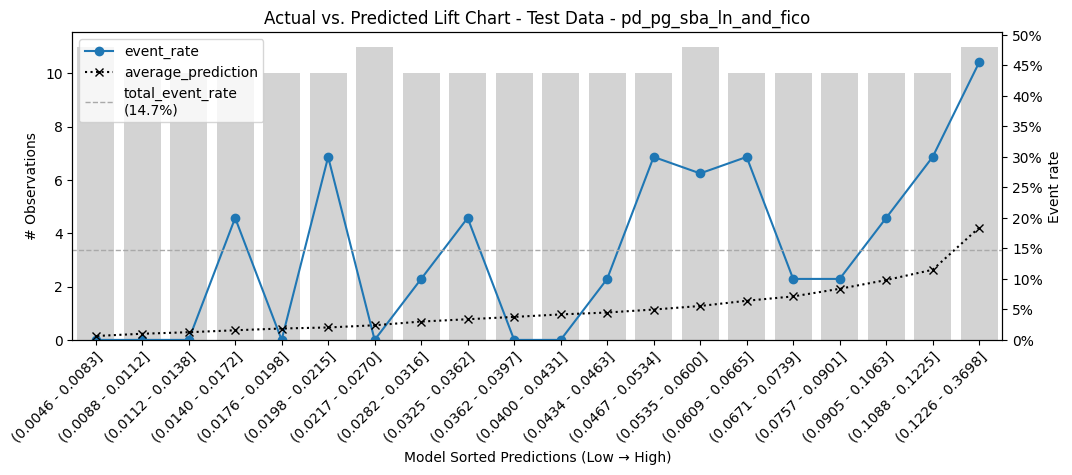

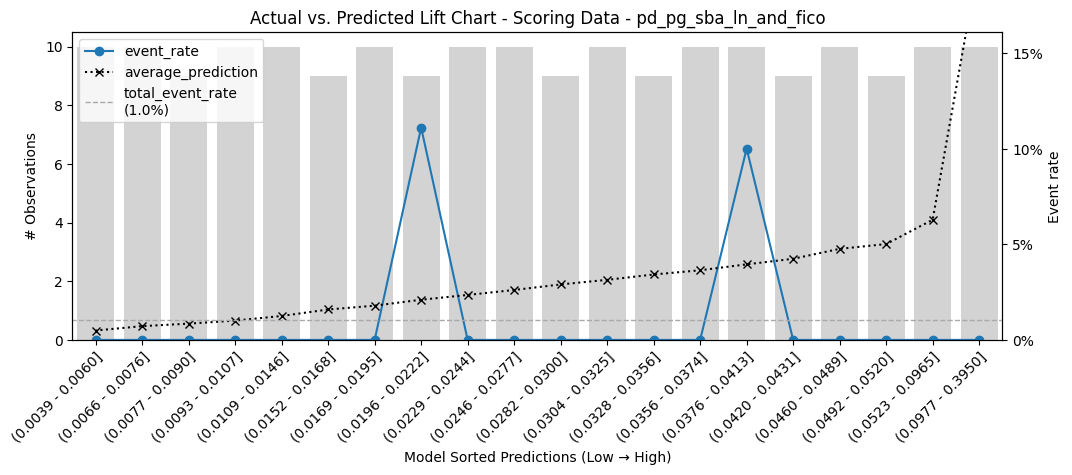

In [37]:


mt.lift_chart_plot('Test Data - pd_pg_sba_ln_and_fico', mt.compute_decile_table(
        data_test_scored[data_test_scored['booked']],
        'pd_pg_sba_ln_and_fico',
        'is_bad',
        20,
        'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_hit'
), 'PROB_RANGE')


mt.lift_chart_plot('Scoring Data - pd_pg_sba_ln_and_fico', mt.compute_decile_table(
        data_scoring_scored[data_scoring_scored['booked']],
        'pd_pg_sba_ln_and_fico',
        'is_bad',
        20,
        'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_hit'
), 'PROB_RANGE')



g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


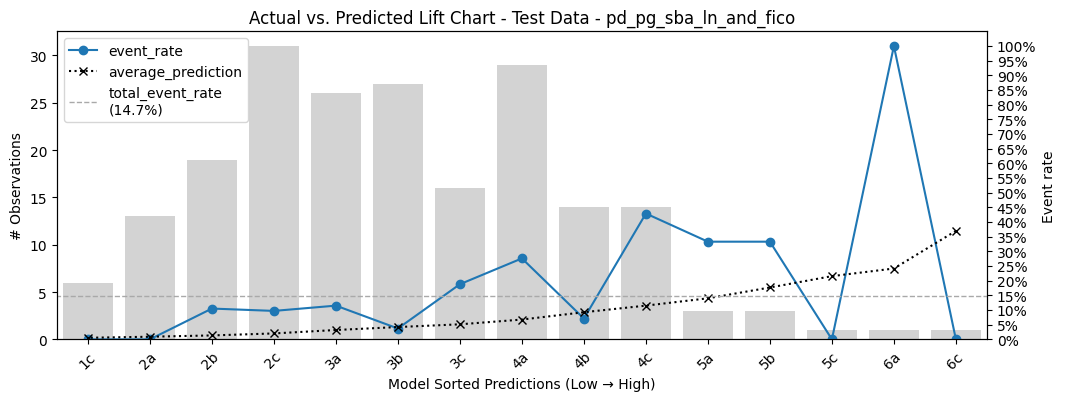

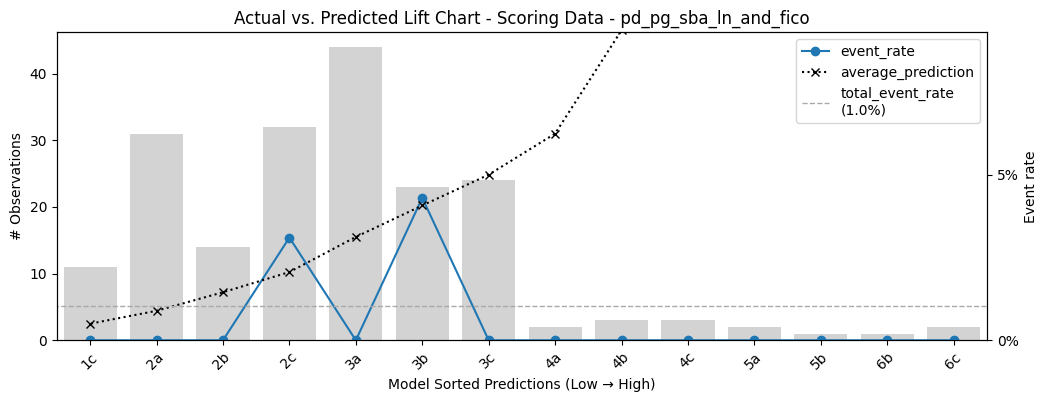

In [38]:

data = data_test_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_hit')]['pd_pg_sba_ln_and_fico'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Test Data - pd_pg_sba_ln_and_fico',mt.compute_risk_grade_table(
        data[data['booked']],
        'pd_pg_sba_ln_and_fico',
        'is_bad',
        20,
        'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_hit',
        'risk_grades'
), 'risk_grades')




data = data_scoring_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_hit')]['pd_pg_sba_ln_and_fico'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Scoring Data - pd_pg_sba_ln_and_fico',mt.compute_risk_grade_table(
        data[data['booked']],
        'pd_pg_sba_ln_and_fico',
        'is_bad',
        20,
        'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_hit',
        'risk_grades'
), 'risk_grades')

In [39]:
data = data_dev_scored.copy()
data = data[(data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_hit')]


# Define fico score bands and ln_score ranges
fico_bands = [580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840]
fico_ranges = list(zip(fico_bands[:-1], fico_bands[1:]))
fico_ranges.append((fico_bands[-1], 900))
ln_bands = [500, 550, 600, 650, 700, 750, 800, 850, 900]
ln_ranges = list(zip(ln_bands[:-1], ln_bands[1:]))
ln_ranges.append((ln_bands[-1], 900))

# Create an empty matrix to store results
results_matrix = pd.DataFrame(index=fico_ranges, columns=ln_ranges)  # Use ln_ranges directly for columns
results_matrix = results_matrix.fillna('')

# Iterate through fico bands and ln_score ranges
for i in range(len(fico_ranges)):
    for j in range(len(ln_ranges)):  # Iterate through all ln_ranges
        fico_lower = fico_ranges[i][0]
        fico_upper = fico_ranges[i][1]
        ln_lower = ln_ranges[j][0]
        ln_upper = ln_ranges[j][1]

        filtered_df = data[
            (data['fico_score'] >= fico_lower) &
            (data['fico_score'] < fico_upper) &
            (data['ln_score'] >= ln_lower) &
            (data['ln_score'] < ln_upper)
        ]

        total_rows = len(filtered_df)
        if total_rows > 0:
            booked_rows = filtered_df['booked'].sum()
            booked_rate = (booked_rows / total_rows) * 100
            results_matrix.iloc[i, j] = f"{total_rows} ({booked_rate:.1f}%)"
        else:
            results_matrix.iloc[i, j] = "0 (0.0%)"

# Display the results matrix
results_matrix

,"(500, 550)","(550, 600)","(600, 650)","(650, 700)","(700, 750)","(750, 800)","(800, 850)","(850, 900)","(900, 900)"
"(580, 600)",0 (0.0%),2 (0.0%),10 (0.0%),11 (0.0%),18 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
"(600, 620)",1 (0.0%),1 (0.0%),7 (0.0%),19 (0.0%),15 (6.7%),1 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
"(620, 640)",3 (33.3%),4 (50.0%),19 (47.4%),34 (58.8%),22 (63.6%),1 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
"(640, 660)",2 (50.0%),1 (100.0%),12 (91.7%),42 (78.6%),40 (80.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%)
"(660, 680)",0 (0.0%),1 (100.0%),9 (88.9%),39 (82.1%),32 (90.6%),2 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%)
"(680, 700)",1 (100.0%),1 (100.0%),7 (57.1%),21 (95.2%),29 (79.3%),4 (75.0%),0 (0.0%),0 (0.0%),0 (0.0%)
"(700, 720)",0 (0.0%),2 (100.0%),3 (100.0%),21 (76.2%),25 (84.0%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%)
"(720, 740)",1 (100.0%),0 (0.0%),6 (66.7%),11 (63.6%),19 (78.9%),1 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
"(740, 760)",0 (0.0%),0 (0.0%),1 (100.0%),8 (50.0%),17 (94.1%),4 (75.0%),0 (0.0%),0 (0.0%),0 (0.0%)
"(760, 780)",0 (0.0%),0 (0.0%),1 (100.0%),4 (75.0%),11 (90.9%),6 (83.3%),0 (0.0%),0 (0.0%),0 (0.0%)


In [40]:
data = data_test_scored.copy()
data = data[(data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_hit')]


# Define fico score bands and ln_score ranges
fico_bands = [580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840]
fico_ranges = list(zip(fico_bands[:-1], fico_bands[1:]))
fico_ranges.append((fico_bands[-1], 900))
ln_bands = [500, 550, 600, 650, 700, 750, 800, 850, 900]
ln_ranges = list(zip(ln_bands[:-1], ln_bands[1:]))
ln_ranges.append((ln_bands[-1], 900))

# Create an empty matrix to store results
results_matrix = pd.DataFrame(index=fico_ranges, columns=ln_ranges)  # Use ln_ranges directly for columns
results_matrix = results_matrix.fillna('')

# Iterate through fico bands and ln_score ranges
for i in range(len(fico_ranges)):
    for j in range(len(ln_ranges)):  # Iterate through all ln_ranges
        fico_lower = fico_ranges[i][0]
        fico_upper = fico_ranges[i][1]
        ln_lower = ln_ranges[j][0]
        ln_upper = ln_ranges[j][1]

        filtered_df = data[
            (data['fico_score'] >= fico_lower) &
            (data['fico_score'] < fico_upper) &
            (data['ln_score'] >= ln_lower) &
            (data['ln_score'] < ln_upper)
        ]

        total_rows = len(filtered_df)
        if total_rows > 0:
            booked_rows = filtered_df['booked'].sum()
            booked_rate = (booked_rows / total_rows) * 100
            results_matrix.iloc[i, j] = f"{total_rows} ({booked_rate:.1f}%)"
        else:
            results_matrix.iloc[i, j] = "0 (0.0%)"

# Display the results matrix
results_matrix

,"(500, 550)","(550, 600)","(600, 650)","(650, 700)","(700, 750)","(750, 800)","(800, 850)","(850, 900)","(900, 900)"
"(580, 600)",0 (0.0%),1 (0.0%),3 (0.0%),8 (0.0%),4 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
"(600, 620)",0 (0.0%),1 (0.0%),3 (0.0%),7 (0.0%),9 (0.0%),2 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
"(620, 640)",1 (100.0%),1 (0.0%),3 (0.0%),14 (64.3%),14 (42.9%),4 (75.0%),0 (0.0%),0 (0.0%),0 (0.0%)
"(640, 660)",0 (0.0%),2 (50.0%),1 (100.0%),9 (88.9%),16 (62.5%),3 (66.7%),0 (0.0%),0 (0.0%),0 (0.0%)
"(660, 680)",1 (100.0%),1 (100.0%),11 (100.0%),14 (92.9%),16 (81.2%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%)
"(680, 700)",0 (0.0%),0 (0.0%),2 (50.0%),11 (90.9%),16 (87.5%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%)
"(700, 720)",1 (100.0%),0 (0.0%),2 (100.0%),11 (90.9%),11 (72.7%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%)
"(720, 740)",0 (0.0%),0 (0.0%),2 (100.0%),6 (83.3%),11 (90.9%),1 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%)
"(740, 760)",0 (0.0%),0 (0.0%),3 (100.0%),8 (87.5%),16 (87.5%),2 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%)
"(760, 780)",0 (0.0%),0 (0.0%),0 (0.0%),4 (75.0%),9 (88.9%),2 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%)


In [41]:
data = data_scoring_scored.copy()
data = data[(data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_hit')]


# Define fico score bands and ln_score ranges
fico_bands = [580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840]
fico_ranges = list(zip(fico_bands[:-1], fico_bands[1:]))
fico_ranges.append((fico_bands[-1], 900))
ln_bands = [500, 550, 600, 650, 700, 750, 800, 850, 900]
ln_ranges = list(zip(ln_bands[:-1], ln_bands[1:]))
ln_ranges.append((ln_bands[-1], 900))

# Create an empty matrix to store results
results_matrix = pd.DataFrame(index=fico_ranges, columns=ln_ranges)  # Use ln_ranges directly for columns
results_matrix = results_matrix.fillna('')

# Iterate through fico bands and ln_score ranges
for i in range(len(fico_ranges)):
    for j in range(len(ln_ranges)):  # Iterate through all ln_ranges
        fico_lower = fico_ranges[i][0]
        fico_upper = fico_ranges[i][1]
        ln_lower = ln_ranges[j][0]
        ln_upper = ln_ranges[j][1]

        filtered_df = data[
            (data['fico_score'] >= fico_lower) &
            (data['fico_score'] < fico_upper) &
            (data['ln_score'] >= ln_lower) &
            (data['ln_score'] < ln_upper)
        ]

        total_rows = len(filtered_df)
        if total_rows > 0:
            booked_rows = filtered_df['booked'].sum()
            booked_rate = (booked_rows / total_rows) * 100
            results_matrix.iloc[i, j] = f"{total_rows} ({booked_rate:.1f}%)"
        else:
            results_matrix.iloc[i, j] = "0 (0.0%)"

# Display the results matrix
results_matrix

,"(500, 550)","(550, 600)","(600, 650)","(650, 700)","(700, 750)","(750, 800)","(800, 850)","(850, 900)","(900, 900)"
"(580, 600)",1 (0.0%),2 (0.0%),11 (0.0%),23 (0.0%),18 (11.1%),1 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
"(600, 620)",0 (0.0%),2 (0.0%),8 (0.0%),15 (0.0%),15 (0.0%),2 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
"(620, 640)",0 (0.0%),0 (0.0%),3 (0.0%),16 (0.0%),14 (14.3%),5 (60.0%),0 (0.0%),0 (0.0%),0 (0.0%)
"(640, 660)",0 (0.0%),0 (0.0%),6 (0.0%),13 (15.4%),18 (38.9%),2 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%)
"(660, 680)",0 (0.0%),2 (0.0%),5 (20.0%),19 (5.3%),25 (88.0%),3 (66.7%),0 (0.0%),0 (0.0%),0 (0.0%)
"(680, 700)",0 (0.0%),0 (0.0%),0 (0.0%),10 (30.0%),19 (89.5%),4 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%)
"(700, 720)",0 (0.0%),0 (0.0%),2 (0.0%),17 (70.6%),15 (93.3%),3 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%)
"(720, 740)",0 (0.0%),0 (0.0%),1 (0.0%),10 (100.0%),14 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%)
"(740, 760)",0 (0.0%),0 (0.0%),1 (100.0%),6 (83.3%),13 (69.2%),5 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%)
"(760, 780)",0 (0.0%),0 (0.0%),0 (0.0%),6 (83.3%),13 (100.0%),6 (83.3%),0 (0.0%),0 (0.0%),0 (0.0%)


#### pd_pg_sba_ln_only

g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


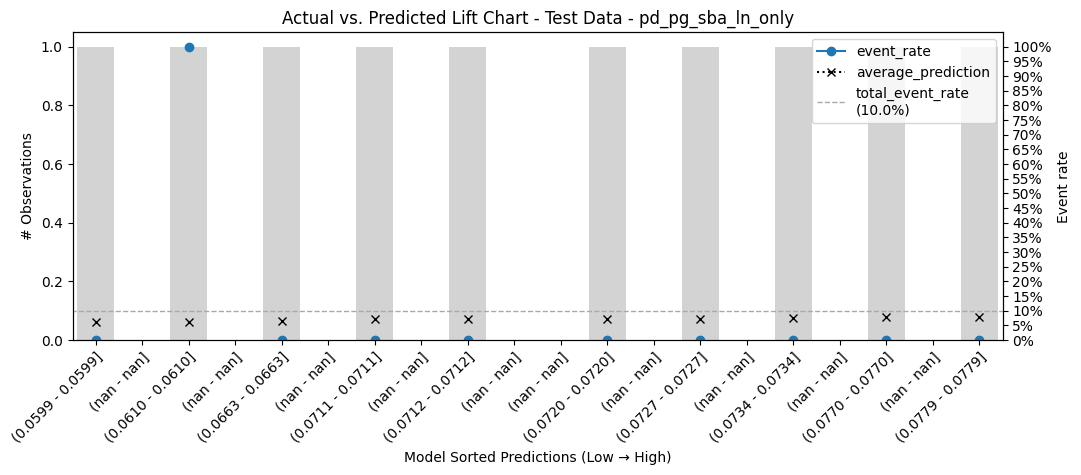

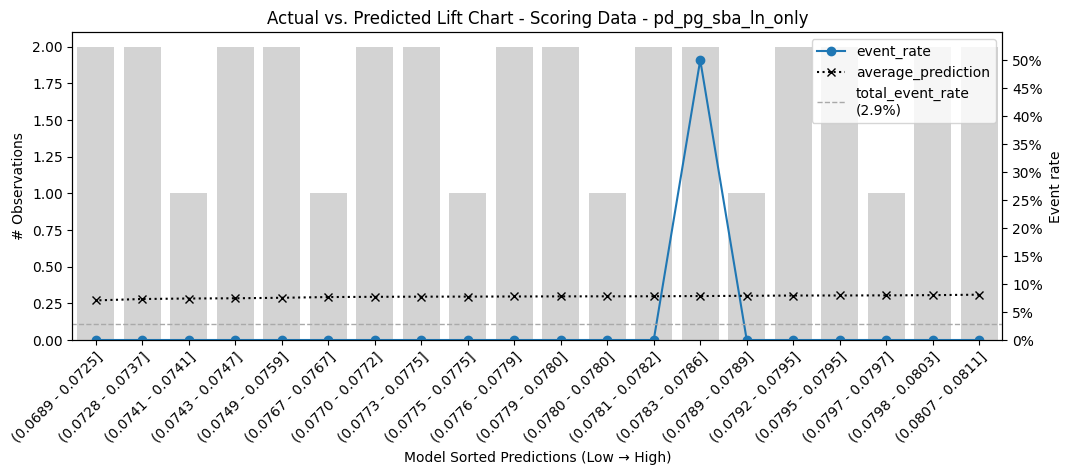

In [42]:


mt.lift_chart_plot('Test Data - pd_pg_sba_ln_only', mt.compute_decile_table(
        data_test_scored[data_test_scored['booked']],
        'pd_pg_sba_ln_only',
        'is_bad',
        20,
        'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_no_hit'
), 'PROB_RANGE')


mt.lift_chart_plot('Scoring Data - pd_pg_sba_ln_only', mt.compute_decile_table(
        data_scoring_scored[data_scoring_scored['booked']],
        'pd_pg_sba_ln_only',
        'is_bad',
        20,
        'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_no_hit'
), 'PROB_RANGE')



g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


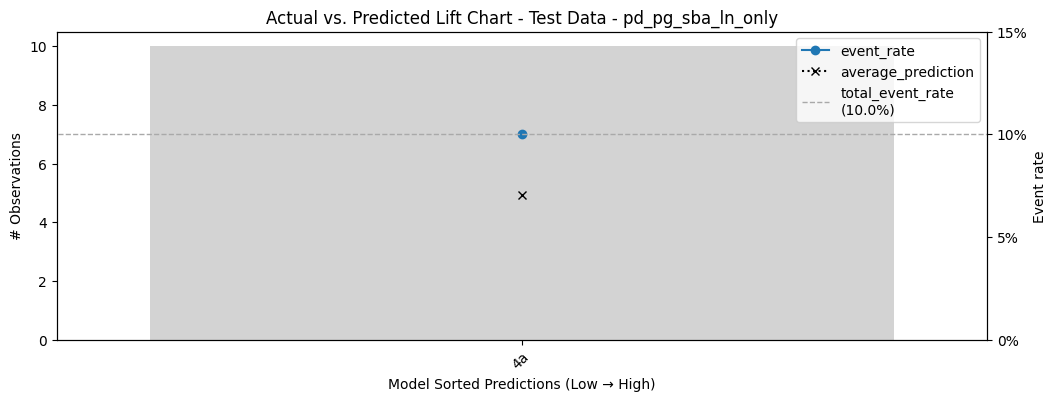

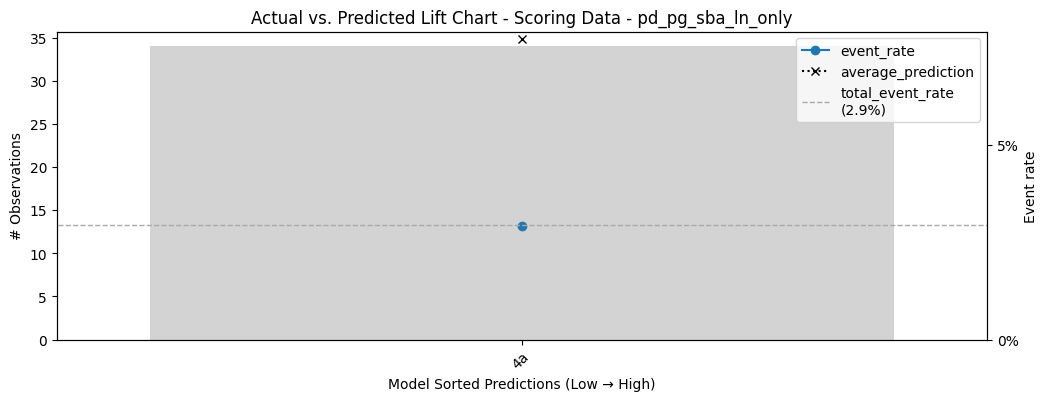

In [43]:

data = data_test_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_no_hit')]['pd_pg_sba_ln_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Test Data - pd_pg_sba_ln_only',mt.compute_risk_grade_table(
        data[data['booked']],
        'pd_pg_sba_ln_only',
        'is_bad',
        20,
        'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_no_hit',
        'risk_grades'
), 'risk_grades')




data = data_scoring_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_no_hit')]['pd_pg_sba_ln_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Scoring Data - pd_pg_sba_ln_only',mt.compute_risk_grade_table(
        data[data['booked']],
        'pd_pg_sba_ln_only',
        'is_bad',
        20,
        'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_no_hit',
        'risk_grades'
), 'risk_grades')

In [44]:
data = data_dev_scored.copy()
data = data[(data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_no_hit')]


# Define fico score bands and ln_score ranges
ln_bands = [500, 550, 600, 650, 700, 750, 800, 850, 900]
ln_ranges = list(zip(ln_bands[:-1], ln_bands[1:]))
ln_ranges.append((ln_bands[-1], 900))


# Create an empty matrix to store results
results_matrix = pd.DataFrame(index=ln_ranges)
results_matrix['counts'] = ''
results_matrix = results_matrix.fillna('')

# Iterate through fico bands and ln_score ranges
for i in range(len(ln_ranges)):
    ln_lower = ln_ranges[i][0]
    ln_upper = ln_ranges[i][1]

    filtered_df = data[
        (data['ln_score'] >= ln_lower) &
        (data['ln_score'] < ln_upper)
    ]

    total_rows = len(filtered_df)
    if total_rows > 0:
        booked_rows = filtered_df['booked'].sum()
        booked_rate = (booked_rows / total_rows) * 100
        results_matrix['counts'].iloc[i] = f"{total_rows} ({booked_rate:.1f}%)"
    else:
        results_matrix['counts'].iloc[i] = "0 (0.0%)"

# Display the results matrix
results_matrix

,counts
"(500, 550)",5 (20.0%)
"(550, 600)",6 (33.3%)
"(600, 650)",17 (11.8%)
"(650, 700)",54 (18.5%)
"(700, 750)",36 (27.8%)
"(750, 800)",5 (60.0%)
"(800, 850)",0 (0.0%)
"(850, 900)",0 (0.0%)
"(900, 900)",0 (0.0%)


In [45]:
data = data_test_scored.copy()
data = data[(data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_no_hit')]


# Define fico score bands and ln_score ranges
ln_bands = [500, 550, 600, 650, 700, 750, 800, 850, 900]
ln_ranges = list(zip(ln_bands[:-1], ln_bands[1:]))
ln_ranges.append((ln_bands[-1], 900))


# Create an empty matrix to store results
results_matrix = pd.DataFrame(index=ln_ranges)
results_matrix['counts'] = ''
results_matrix = results_matrix.fillna('')

# Iterate through fico bands and ln_score ranges
for i in range(len(ln_ranges)):
    ln_lower = ln_ranges[i][0]
    ln_upper = ln_ranges[i][1]

    filtered_df = data[
        (data['ln_score'] >= ln_lower) &
        (data['ln_score'] < ln_upper)
    ]

    total_rows = len(filtered_df)
    if total_rows > 0:
        booked_rows = filtered_df['booked'].sum()
        booked_rate = (booked_rows / total_rows) * 100
        results_matrix['counts'].iloc[i] = f"{total_rows} ({booked_rate:.1f}%)"
    else:
        results_matrix['counts'].iloc[i] = "0 (0.0%)"

# Display the results matrix
results_matrix

,counts
"(500, 550)",1 (0.0%)
"(550, 600)",13 (15.4%)
"(600, 650)",13 (7.7%)
"(650, 700)",52 (7.7%)
"(700, 750)",25 (12.0%)
"(750, 800)",2 (0.0%)
"(800, 850)",0 (0.0%)
"(850, 900)",0 (0.0%)
"(900, 900)",0 (0.0%)


In [46]:
data = data_scoring_scored.copy()
data = data[(data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_no_hit')]


# Define fico score bands and ln_score ranges
ln_bands = [500, 550, 600, 650, 700, 750, 800, 850, 900]
ln_ranges = list(zip(ln_bands[:-1], ln_bands[1:]))
ln_ranges.append((ln_bands[-1], 900))


# Create an empty matrix to store results
results_matrix = pd.DataFrame(index=ln_ranges)
results_matrix['counts'] = ''
results_matrix = results_matrix.fillna('')

# Iterate through fico bands and ln_score ranges
for i in range(len(ln_ranges)):
    ln_lower = ln_ranges[i][0]
    ln_upper = ln_ranges[i][1]

    filtered_df = data[
        (data['ln_score'] >= ln_lower) &
        (data['ln_score'] < ln_upper)
    ]

    total_rows = len(filtered_df)
    if total_rows > 0:
        booked_rows = filtered_df['booked'].sum()
        booked_rate = (booked_rows / total_rows) * 100
        results_matrix['counts'].iloc[i] = f"{total_rows} ({booked_rate:.1f}%)"
    else:
        results_matrix['counts'].iloc[i] = "0 (0.0%)"

# Display the results matrix
results_matrix

,counts
"(500, 550)",0 (0.0%)
"(550, 600)",5 (0.0%)
"(600, 650)",20 (0.0%)
"(650, 700)",63 (3.2%)
"(700, 750)",56 (33.9%)
"(750, 800)",15 (86.7%)
"(800, 850)",0 (0.0%)
"(850, 900)",0 (0.0%)
"(900, 900)",0 (0.0%)


#### pd_pg_fico_only

g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


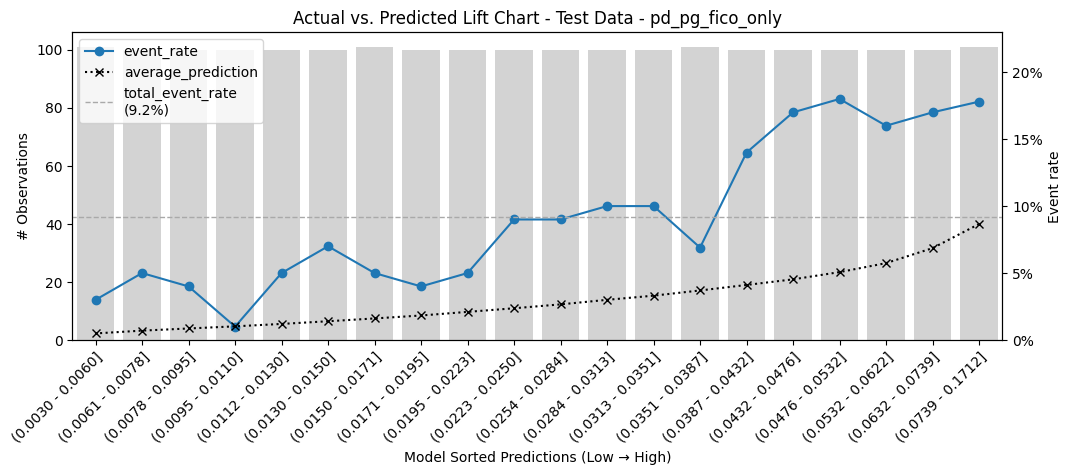

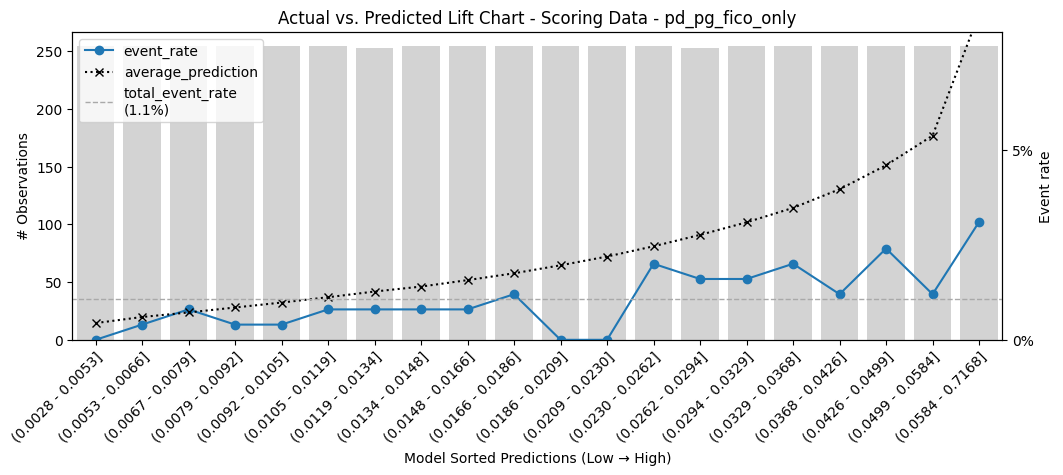

In [47]:


mt.lift_chart_plot('Test Data - pd_pg_fico_only', mt.compute_decile_table(
        data_test_scored[data_test_scored['booked']],
        'pd_pg_fico_only',
        'is_bad',
        20,
        'pg_and_no_sbfe_tradeline_and_no_sba_tradeline_and_fico_hit'
), 'PROB_RANGE')


mt.lift_chart_plot('Scoring Data - pd_pg_fico_only', mt.compute_decile_table(
        data_scoring_scored[data_scoring_scored['booked']],
        'pd_pg_fico_only',
        'is_bad',
        20,
        'pg_and_no_sbfe_tradeline_and_no_sba_tradeline_and_fico_hit'
), 'PROB_RANGE')



g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


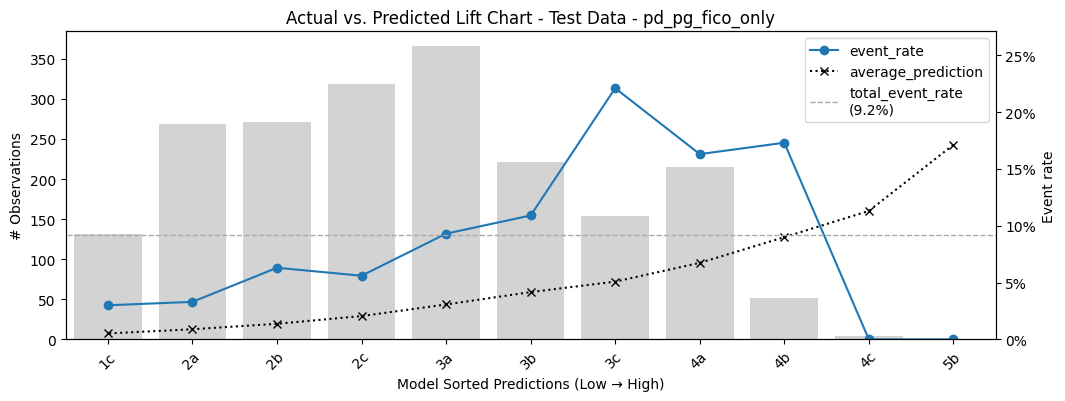

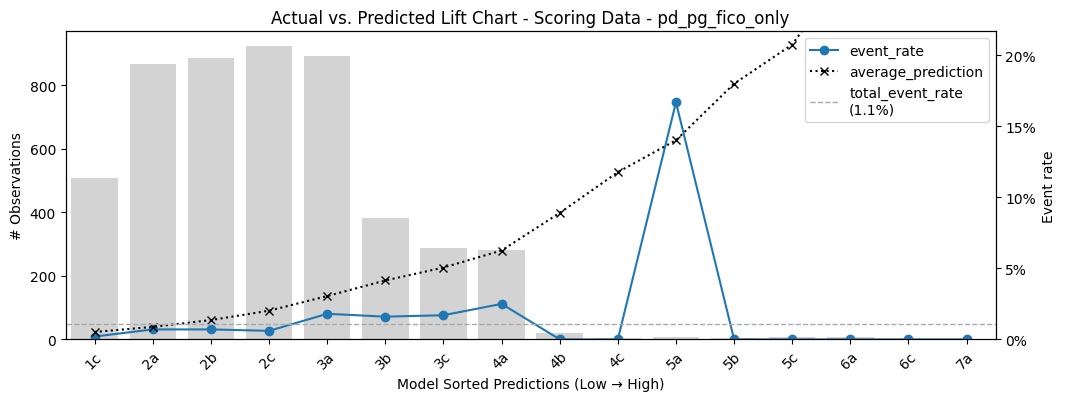

In [48]:

data = data_test_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_no_sba_tradeline_and_fico_hit')]['pd_pg_fico_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Test Data - pd_pg_fico_only',mt.compute_risk_grade_table(
        data[data['booked']],
        'pd_pg_fico_only',
        'is_bad',
        20,
        'pg_and_no_sbfe_tradeline_and_no_sba_tradeline_and_fico_hit',
        'risk_grades'
), 'risk_grades')




data = data_scoring_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_no_sba_tradeline_and_fico_hit')]['pd_pg_fico_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Scoring Data - pd_pg_fico_only',mt.compute_risk_grade_table(
        data[data['booked']],
        'pd_pg_fico_only',
        'is_bad',
        20,
        'pg_and_no_sbfe_tradeline_and_no_sba_tradeline_and_fico_hit',
        'risk_grades'
), 'risk_grades')

In [49]:
data = data_dev_scored.copy()
data = data[(data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_no_sba_tradeline_and_fico_hit')]


# Define fico score bands and ln_score ranges
fico_bands = [580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840]
fico_ranges = list(zip(fico_bands[:-1], fico_bands[1:]))
fico_ranges.append((fico_bands[-1], 900))


# Create an empty matrix to store results
results_matrix = pd.DataFrame(index=fico_ranges)
results_matrix['counts'] = ''
results_matrix = results_matrix.fillna('')

# Iterate through fico bands and ln_score ranges
for i in range(len(fico_ranges)):
    fico_lower = fico_ranges[i][0]
    fico_upper = fico_ranges[i][1]

    filtered_df = data[
        (data['fico_score'] >= fico_lower) &
        (data['fico_score'] < fico_upper)
    ]

    total_rows = len(filtered_df)
    if total_rows > 0:
        booked_rows = filtered_df['booked'].sum()
        booked_rate = (booked_rows / total_rows) * 100
        results_matrix['counts'].iloc[i] = f"{total_rows} ({booked_rate:.1f}%)"
    else:
        results_matrix['counts'].iloc[i] = "0 (0.0%)"

# Display the results matrix
results_matrix

,counts
"(580, 600)",419 (1.9%)
"(600, 620)",507 (3.4%)
"(620, 640)",830 (51.9%)
"(640, 660)",1148 (76.5%)
"(660, 680)",1196 (78.7%)
"(680, 700)",1109 (83.9%)
"(700, 720)",1080 (83.7%)
"(720, 740)",990 (83.5%)
"(740, 760)",894 (84.5%)
"(760, 780)",713 (85.6%)


In [50]:
data = data_test_scored.copy()
data = data[(data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_no_sba_tradeline_and_fico_hit')]


# Define fico score bands and ln_score ranges
fico_bands = [580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840]
fico_ranges = list(zip(fico_bands[:-1], fico_bands[1:]))
fico_ranges.append((fico_bands[-1], 900))


# Create an empty matrix to store results
results_matrix = pd.DataFrame(index=fico_ranges)
results_matrix['counts'] = ''
results_matrix = results_matrix.fillna('')

# Iterate through fico bands and ln_score ranges
for i in range(len(fico_ranges)):
    fico_lower = fico_ranges[i][0]
    fico_upper = fico_ranges[i][1]

    filtered_df = data[
        (data['fico_score'] >= fico_lower) &
        (data['fico_score'] < fico_upper)
    ]

    total_rows = len(filtered_df)
    if total_rows > 0:
        booked_rows = filtered_df['booked'].sum()
        booked_rate = (booked_rows / total_rows) * 100
        results_matrix['counts'].iloc[i] = f"{total_rows} ({booked_rate:.1f}%)"
    else:
        results_matrix['counts'].iloc[i] = "0 (0.0%)"

# Display the results matrix
results_matrix

,counts
"(580, 600)",107 (0.9%)
"(600, 620)",125 (3.2%)
"(620, 640)",221 (47.1%)
"(640, 660)",315 (59.0%)
"(660, 680)",376 (81.1%)
"(680, 700)",357 (86.3%)
"(700, 720)",307 (85.7%)
"(720, 740)",289 (86.9%)
"(740, 760)",239 (87.0%)
"(760, 780)",225 (84.4%)


In [51]:
data = data_scoring_scored.copy()
data = data[(data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_no_sba_tradeline_and_fico_hit')]


# Define fico score bands and ln_score ranges
fico_bands = [580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840]
fico_ranges = list(zip(fico_bands[:-1], fico_bands[1:]))
fico_ranges.append((fico_bands[-1], 900))


# Create an empty matrix to store results
results_matrix = pd.DataFrame(index=fico_ranges)
results_matrix['counts'] = ''
results_matrix = results_matrix.fillna('')

# Iterate through fico bands and ln_score ranges
for i in range(len(fico_ranges)):
    fico_lower = fico_ranges[i][0]
    fico_upper = fico_ranges[i][1]

    filtered_df = data[
        (data['fico_score'] >= fico_lower) &
        (data['fico_score'] < fico_upper)
    ]

    total_rows = len(filtered_df)
    if total_rows > 0:
        booked_rows = filtered_df['booked'].sum()
        booked_rate = (booked_rows / total_rows) * 100
        results_matrix['counts'].iloc[i] = f"{total_rows} ({booked_rate:.1f}%)"
    else:
        results_matrix['counts'].iloc[i] = "0 (0.0%)"

# Display the results matrix
results_matrix

,counts
"(580, 600)",376 (1.3%)
"(600, 620)",438 (1.4%)
"(620, 640)",524 (8.4%)
"(640, 660)",674 (45.8%)
"(660, 680)",757 (69.7%)
"(680, 700)",861 (80.4%)
"(700, 720)",838 (87.1%)
"(720, 740)",837 (88.5%)
"(740, 760)",796 (90.2%)
"(760, 780)",640 (90.8%)


#### pd_no_pg_sbfe_ln_only

g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


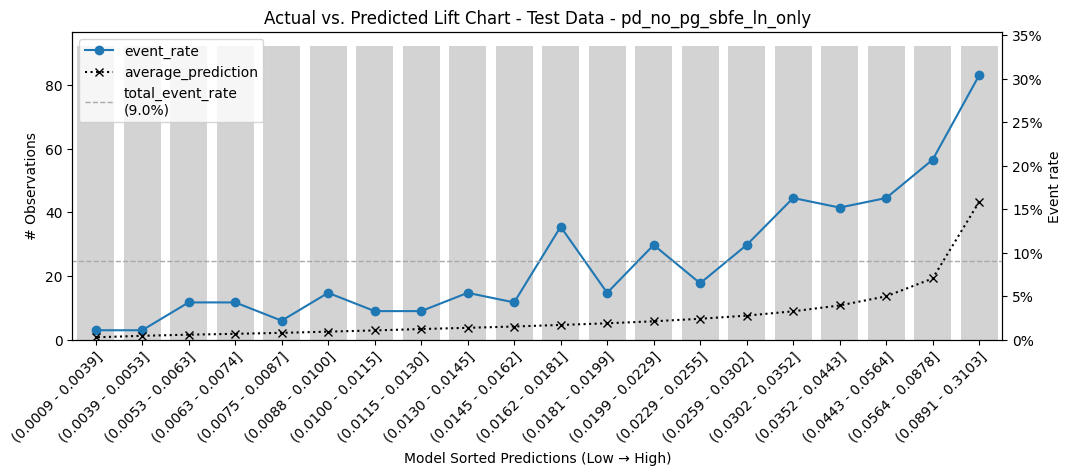

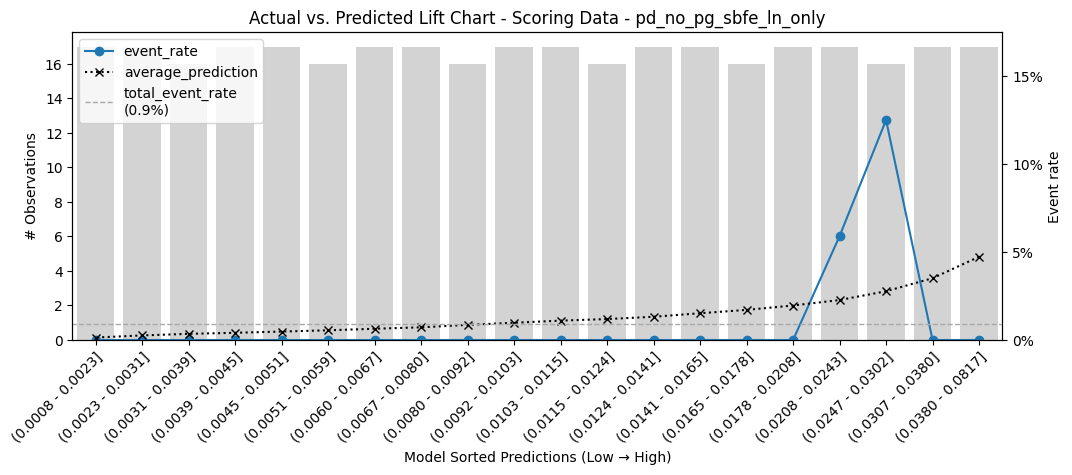

In [52]:

mt.lift_chart_plot('Test Data - pd_no_pg_sbfe_ln_only', mt.compute_decile_table(
        data_test_scored[data_test_scored['booked']],
        'pd_no_pg_sbfe_ln_only',
        'is_bad',
        20,
        'no_pg_and_1_plus_sbfe_tradeline'
), 'PROB_RANGE')


mt.lift_chart_plot('Scoring Data - pd_no_pg_sbfe_ln_only', mt.compute_decile_table(
        data_scoring_scored[data_scoring_scored['booked']],
        'pd_no_pg_sbfe_ln_only',
        'is_bad',
        20,
        'no_pg_and_1_plus_sbfe_tradeline'
), 'PROB_RANGE')



g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


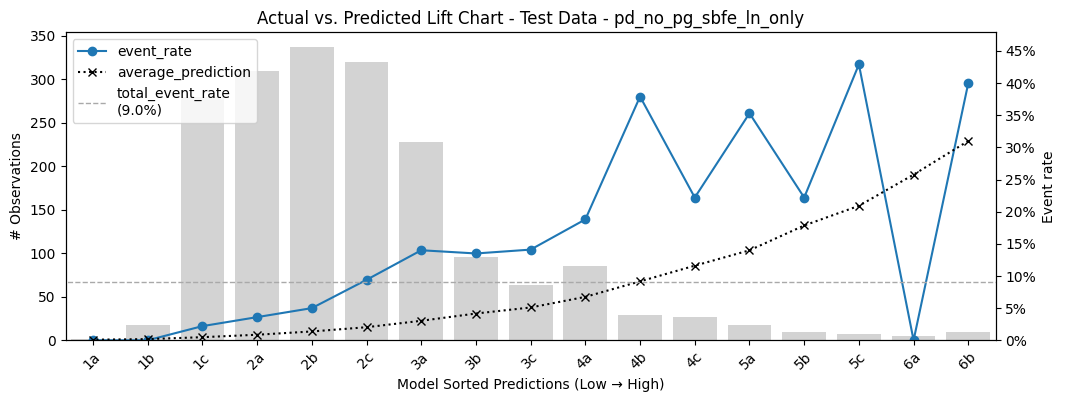

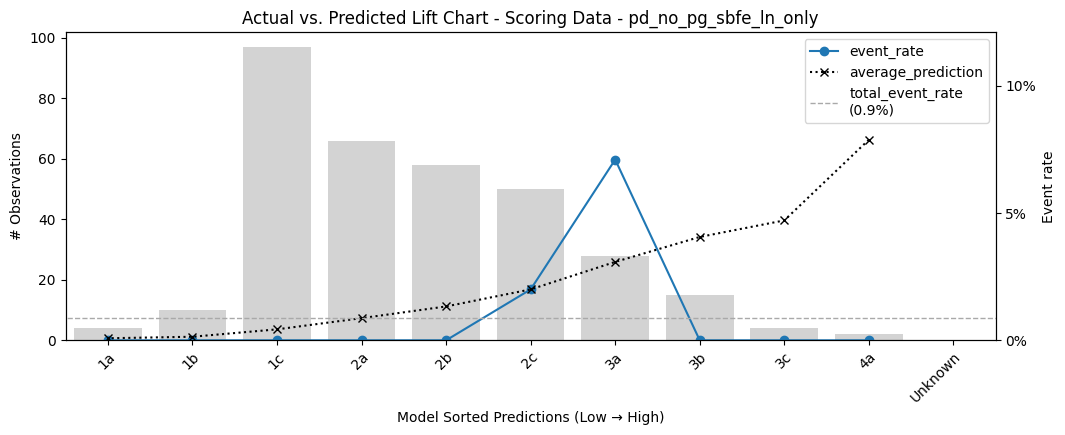

In [53]:

data = data_test_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'no_pg_and_1_plus_sbfe_tradeline')]['pd_no_pg_sbfe_ln_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Test Data - pd_no_pg_sbfe_ln_only',mt.compute_risk_grade_table(
        data[data['booked']],
        'pd_no_pg_sbfe_ln_only',
        'is_bad',
        20,
        'no_pg_and_1_plus_sbfe_tradeline',
        'risk_grades'
), 'risk_grades')




data = data_scoring_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'no_pg_and_1_plus_sbfe_tradeline')]['pd_no_pg_sbfe_ln_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Scoring Data - pd_no_pg_sbfe_ln_only',mt.compute_risk_grade_table(
        data[data['booked']],
        'pd_no_pg_sbfe_ln_only',
        'is_bad',
        20,
        'no_pg_and_1_plus_sbfe_tradeline',
        'risk_grades'
), 'risk_grades')

In [54]:
data = data_dev_scored.copy()
data = data[(data['risk_grade_path'] == 'no_pg_and_1_plus_sbfe_tradeline')]


# Define fico score bands and ln_score ranges
ln_bands = [500, 550, 600, 650, 700, 750, 800, 850, 900]
ln_ranges = list(zip(ln_bands[:-1], ln_bands[1:]))
ln_ranges.append((ln_bands[-1], 900))


# Create an empty matrix to store results
results_matrix = pd.DataFrame(index=ln_ranges)
results_matrix['counts'] = ''
results_matrix = results_matrix.fillna('')

# Iterate through fico bands and ln_score ranges
for i in range(len(ln_ranges)):
    ln_lower = ln_ranges[i][0]
    ln_upper = ln_ranges[i][1]

    filtered_df = data[
        (data['ln_score'] >= ln_lower) &
        (data['ln_score'] < ln_upper)
    ]

    total_rows = len(filtered_df)
    if total_rows > 0:
        booked_rows = filtered_df['booked'].sum()
        booked_rate = (booked_rows / total_rows) * 100
        results_matrix['counts'].iloc[i] = f"{total_rows} ({booked_rate:.1f}%)"
    else:
        results_matrix['counts'].iloc[i] = "0 (0.0%)"

# Display the results matrix
results_matrix

,counts
"(500, 550)",98 (69.4%)
"(550, 600)",240 (72.1%)
"(600, 650)",845 (84.5%)
"(650, 700)",1490 (85.3%)
"(700, 750)",1636 (86.6%)
"(750, 800)",841 (89.1%)
"(800, 850)",168 (88.1%)
"(850, 900)",18 (83.3%)
"(900, 900)",0 (0.0%)


In [55]:
data = data_test_scored.copy()
data = data[(data['risk_grade_path'] == 'no_pg_and_1_plus_sbfe_tradeline')]


# Define fico score bands and ln_score ranges
ln_bands = [500, 550, 600, 650, 700, 750, 800, 850, 900]
ln_ranges = list(zip(ln_bands[:-1], ln_bands[1:]))
ln_ranges.append((ln_bands[-1], 900))


# Create an empty matrix to store results
results_matrix = pd.DataFrame(index=ln_ranges)
results_matrix['counts'] = ''
results_matrix = results_matrix.fillna('')

# Iterate through fico bands and ln_score ranges
for i in range(len(ln_ranges)):
    ln_lower = ln_ranges[i][0]
    ln_upper = ln_ranges[i][1]

    filtered_df = data[
        (data['ln_score'] >= ln_lower) &
        (data['ln_score'] < ln_upper)
    ]

    total_rows = len(filtered_df)
    if total_rows > 0:
        booked_rows = filtered_df['booked'].sum()
        booked_rate = (booked_rows / total_rows) * 100
        results_matrix['counts'].iloc[i] = f"{total_rows} ({booked_rate:.1f}%)"
    else:
        results_matrix['counts'].iloc[i] = "0 (0.0%)"

# Display the results matrix
results_matrix

,counts
"(500, 550)",100 (28.0%)
"(550, 600)",137 (51.1%)
"(600, 650)",298 (70.1%)
"(650, 700)",591 (82.4%)
"(700, 750)",669 (88.0%)
"(750, 800)",403 (90.6%)
"(800, 850)",94 (90.4%)
"(850, 900)",7 (100.0%)
"(900, 900)",0 (0.0%)


In [56]:
data = data_scoring_scored.copy()
data = data[(data['risk_grade_path'] == 'no_pg_and_1_plus_sbfe_tradeline')]


# Define fico score bands and ln_score ranges
ln_bands = [500, 550, 600, 650, 700, 750, 800, 850, 900]
ln_ranges = list(zip(ln_bands[:-1], ln_bands[1:]))
ln_ranges.append((ln_bands[-1], 900))


# Create an empty matrix to store results
results_matrix = pd.DataFrame(index=ln_ranges)
results_matrix['counts'] = ''
results_matrix = results_matrix.fillna('')

# Iterate through fico bands and ln_score ranges
for i in range(len(ln_ranges)):
    ln_lower = ln_ranges[i][0]
    ln_upper = ln_ranges[i][1]

    filtered_df = data[
        (data['ln_score'] >= ln_lower) &
        (data['ln_score'] < ln_upper)
    ]

    total_rows = len(filtered_df)
    if total_rows > 0:
        booked_rows = filtered_df['booked'].sum()
        booked_rate = (booked_rows / total_rows) * 100
        results_matrix['counts'].iloc[i] = f"{total_rows} ({booked_rate:.1f}%)"
    else:
        results_matrix['counts'].iloc[i] = "0 (0.0%)"

# Display the results matrix
results_matrix

,counts
"(500, 550)",6 (0.0%)
"(550, 600)",8 (0.0%)
"(600, 650)",32 (37.5%)
"(650, 700)",83 (80.7%)
"(700, 750)",127 (89.0%)
"(750, 800)",95 (94.7%)
"(800, 850)",44 (90.9%)
"(850, 900)",9 (100.0%)
"(900, 900)",0 (0.0%)


#### pd_no_pg_sba_ln_only

g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


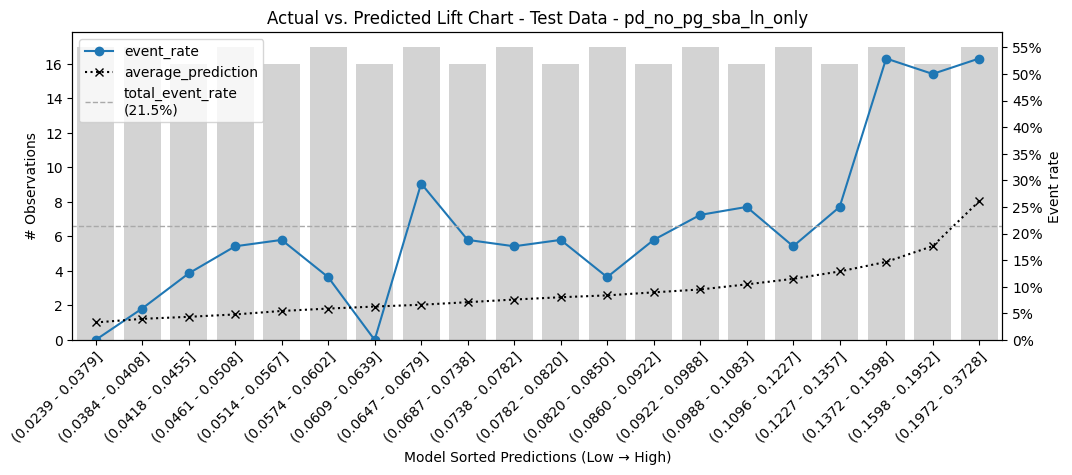

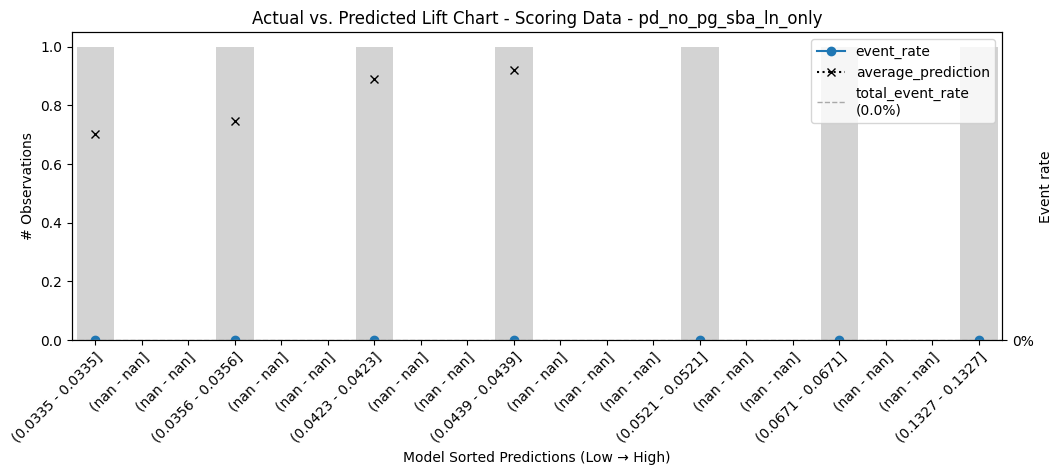

In [57]:



mt.lift_chart_plot('Test Data - pd_no_pg_sba_ln_only', mt.compute_decile_table(
        data_test_scored[data_test_scored['booked']],
        'pd_no_pg_sba_ln_only',
        'is_bad',
        20,
        'no_pg_and_no_1_plus_sbfe_tradeline_and_1_plus_sba_tradeline'
), 'PROB_RANGE')


mt.lift_chart_plot('Scoring Data - pd_no_pg_sba_ln_only', mt.compute_decile_table(
        data_scoring_scored[data_scoring_scored['booked']],
        'pd_no_pg_sba_ln_only',
        'is_bad',
        20,
        'no_pg_and_no_1_plus_sbfe_tradeline_and_1_plus_sba_tradeline'
), 'PROB_RANGE')



g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:714: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


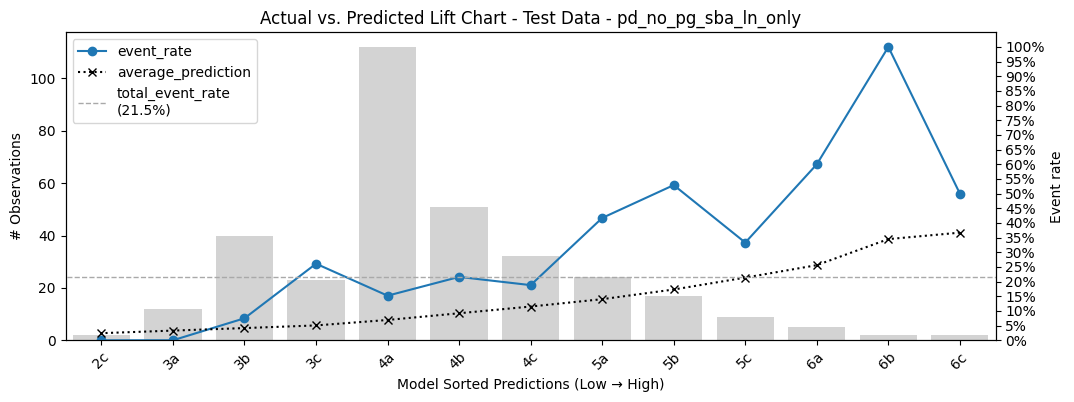

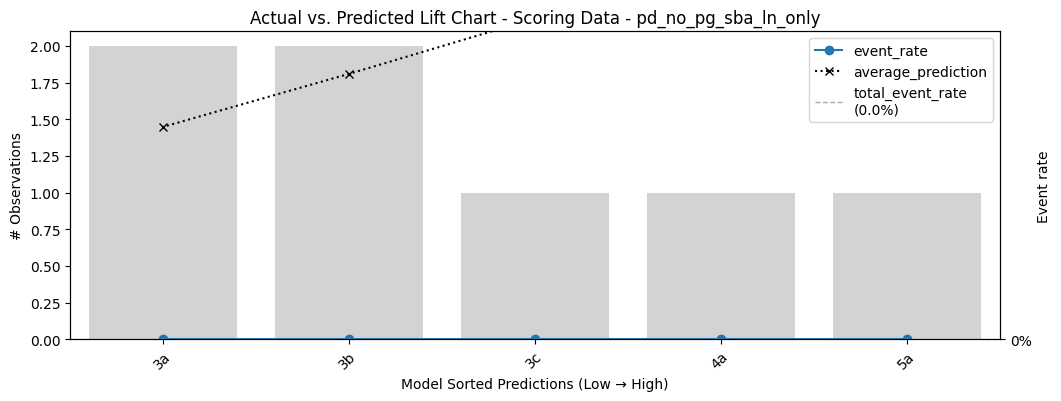

In [58]:

data = data_test_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'no_pg_and_no_1_plus_sbfe_tradeline_and_1_plus_sba_tradeline')]['pd_no_pg_sba_ln_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Test Data - pd_no_pg_sba_ln_only',mt.compute_risk_grade_table(
        data[data['booked']],
        'pd_no_pg_sba_ln_only',
        'is_bad',
        20,
        'no_pg_and_no_1_plus_sbfe_tradeline_and_1_plus_sba_tradeline',
        'risk_grades'
), 'risk_grades')




data = data_scoring_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'no_pg_and_no_1_plus_sbfe_tradeline_and_1_plus_sba_tradeline')]['pd_no_pg_sba_ln_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Scoring Data - pd_no_pg_sba_ln_only',mt.compute_risk_grade_table(
        data[data['booked']],
        'pd_no_pg_sba_ln_only',
        'is_bad',
        20,
        'no_pg_and_no_1_plus_sbfe_tradeline_and_1_plus_sba_tradeline',
        'risk_grades'
), 'risk_grades')

In [59]:
data = data_dev_scored.copy()
data = data[(data['risk_grade_path'] == 'no_pg_and_no_1_plus_sbfe_tradeline_and_1_plus_sba_tradeline')]


# Define fico score bands and ln_score ranges
ln_bands = [500, 550, 600, 650, 700, 750, 800, 850, 900]
ln_ranges = list(zip(ln_bands[:-1], ln_bands[1:]))
ln_ranges.append((ln_bands[-1], 900))


# Create an empty matrix to store results
results_matrix = pd.DataFrame(index=ln_ranges)
results_matrix['counts'] = ''
results_matrix = results_matrix.fillna('')

# Iterate through fico bands and ln_score ranges
for i in range(len(ln_ranges)):
    ln_lower = ln_ranges[i][0]
    ln_upper = ln_ranges[i][1]

    filtered_df = data[
        (data['ln_score'] >= ln_lower) &
        (data['ln_score'] < ln_upper)
    ]

    total_rows = len(filtered_df)
    if total_rows > 0:
        booked_rows = filtered_df['booked'].sum()
        booked_rate = (booked_rows / total_rows) * 100
        results_matrix['counts'].iloc[i] = f"{total_rows} ({booked_rate:.1f}%)"
    else:
        results_matrix['counts'].iloc[i] = "0 (0.0%)"

# Display the results matrix
results_matrix

,counts
"(500, 550)",40 (55.0%)
"(550, 600)",76 (61.8%)
"(600, 650)",252 (70.2%)
"(650, 700)",641 (76.3%)
"(700, 750)",593 (81.6%)
"(750, 800)",79 (82.3%)
"(800, 850)",1 (100.0%)
"(850, 900)",0 (0.0%)
"(900, 900)",0 (0.0%)


In [60]:
data = data_test_scored.copy()
data = data[(data['risk_grade_path'] == 'no_pg_and_no_1_plus_sbfe_tradeline_and_1_plus_sba_tradeline')]


# Define fico score bands and ln_score ranges
ln_bands = [500, 550, 600, 650, 700, 750, 800, 850, 900]
ln_ranges = list(zip(ln_bands[:-1], ln_bands[1:]))
ln_ranges.append((ln_bands[-1], 900))


# Create an empty matrix to store results
results_matrix = pd.DataFrame(index=ln_ranges)
results_matrix['counts'] = ''
results_matrix = results_matrix.fillna('')

# Iterate through fico bands and ln_score ranges
for i in range(len(ln_ranges)):
    ln_lower = ln_ranges[i][0]
    ln_upper = ln_ranges[i][1]

    filtered_df = data[
        (data['ln_score'] >= ln_lower) &
        (data['ln_score'] < ln_upper)
    ]

    total_rows = len(filtered_df)
    if total_rows > 0:
        booked_rows = filtered_df['booked'].sum()
        booked_rate = (booked_rows / total_rows) * 100
        results_matrix['counts'].iloc[i] = f"{total_rows} ({booked_rate:.1f}%)"
    else:
        results_matrix['counts'].iloc[i] = "0 (0.0%)"

# Display the results matrix
results_matrix

,counts
"(500, 550)",13 (15.4%)
"(550, 600)",31 (29.0%)
"(600, 650)",86 (47.7%)
"(650, 700)",198 (62.6%)
"(700, 750)",180 (67.2%)
"(750, 800)",39 (87.2%)
"(800, 850)",0 (0.0%)
"(850, 900)",0 (0.0%)
"(900, 900)",0 (0.0%)


In [61]:
data = data_scoring_scored.copy()
data = data[(data['risk_grade_path'] == 'no_pg_and_no_1_plus_sbfe_tradeline_and_1_plus_sba_tradeline')]


# Define fico score bands and ln_score ranges
ln_bands = [500, 550, 600, 650, 700, 750, 800, 850, 900]
ln_ranges = list(zip(ln_bands[:-1], ln_bands[1:]))
ln_ranges.append((ln_bands[-1], 900))


# Create an empty matrix to store results
results_matrix = pd.DataFrame(index=ln_ranges)
results_matrix['counts'] = ''
results_matrix = results_matrix.fillna('')

# Iterate through fico bands and ln_score ranges
for i in range(len(ln_ranges)):
    ln_lower = ln_ranges[i][0]
    ln_upper = ln_ranges[i][1]

    filtered_df = data[
        (data['ln_score'] >= ln_lower) &
        (data['ln_score'] < ln_upper)
    ]

    total_rows = len(filtered_df)
    if total_rows > 0:
        booked_rows = filtered_df['booked'].sum()
        booked_rate = (booked_rows / total_rows) * 100
        results_matrix['counts'].iloc[i] = f"{total_rows} ({booked_rate:.1f}%)"
    else:
        results_matrix['counts'].iloc[i] = "0 (0.0%)"

# Display the results matrix
results_matrix

,counts
"(500, 550)",0 (0.0%)
"(550, 600)",3 (0.0%)
"(600, 650)",1 (0.0%)
"(650, 700)",10 (10.0%)
"(700, 750)",12 (33.3%)
"(750, 800)",2 (100.0%)
"(800, 850)",0 (0.0%)
"(850, 900)",0 (0.0%)
"(900, 900)",0 (0.0%)
